In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]
        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class ContinuousAtrousConvModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContinuousAtrousConvModule, self).__init__()
        middle_channels = out_channels // 3
        self.atrous_conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size=3, dilation=1, padding=1)
        self.atrous_conv2 = nn.Conv2d(in_channels, middle_channels, kernel_size=3, dilation=2, padding=2)
        self.atrous_conv3 = nn.Conv2d(in_channels, out_channels - 2 * middle_channels, kernel_size=3, dilation=4, padding=4)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)
        #self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x1 = self.atrous_conv1(x)
        x2 = self.atrous_conv2(x)
        x3 = self.atrous_conv3(x)
        x = torch.cat([x1, x2, x3], dim=1)
        x = self.bn(x)
        x = self.relu(x)
        #x = self.global_pool(x)
        return x


class ImprovedSkipLayer(nn.Module):
    def __init__(self, low_level_channels, mid_level_channels, high_level_channels, num_classes):
        super(ImprovedSkipLayer, self).__init__()
        self.conv_low = nn.Conv2d(low_level_channels, num_classes, kernel_size=1)
        self.conv_mid = nn.Conv2d(mid_level_channels, num_classes, kernel_size=1)
        self.conv_high = nn.Conv2d(high_level_channels, num_classes, kernel_size=1)

    def forward(self, x_low, x_mid, x_high, x_upsampled):
        x_low_processed = self.conv_low(x_low)
        x_mid_processed = self.conv_mid(x_mid)
        x_high_processed = self.conv_high(x_high)

        x_upsampled_8x = F.interpolate(x_upsampled, size=x_high_processed.shape[2:], mode='bilinear', align_corners=False)
        high_fusion = x_high_processed + x_upsampled_8x

        high_fusion_upsampled = F.interpolate(high_fusion, size=x_mid_processed.shape[2:], mode='bilinear', align_corners=False)
        mid_fusion = x_mid_processed + high_fusion_upsampled

        mid_fusion_upsampled = F.interpolate(mid_fusion, size=x_low_processed.shape[2:], mode='bilinear', align_corners=False)
        final_fusion = x_low_processed + mid_fusion_upsampled

        output = F.interpolate(final_fusion, size=(640, 640), mode='bilinear', align_corners=False)
        return output


class ImprovedFCN_MobileNetV2(nn.Module):
    def __init__(self, num_classes=7):
        super(ImprovedFCN_MobileNetV2, self).__init__()
        mobilenet = mobilenet_v2(pretrained=True)

        self.low_level_features = nn.Sequential(
            mobilenet.features[0],
            mobilenet.features[1],
        )

        self.mid_level_features = nn.Sequential(
            mobilenet.features[2],
            mobilenet.features[3],
        )

        self.high_level_features = nn.Sequential(
            mobilenet.features[4],
            mobilenet.features[5],
            mobilenet.features[6],
            mobilenet.features[7],
            mobilenet.features[8],
            mobilenet.features[9],
            mobilenet.features[10],
        )

        self.deeper_features = nn.Sequential(
            mobilenet.features[11],
            mobilenet.features[12],
            mobilenet.features[13],
            mobilenet.features[14],
            mobilenet.features[15],
            mobilenet.features[16],
            mobilenet.features[17],
        )

        self.channel_expansion = nn.Conv2d(320, 1024, kernel_size=1, bias=False)
        self.bn_expansion = nn.BatchNorm2d(1024)
        self.relu_expansion = nn.ReLU6(inplace=True)

        self.continuous_atrous = ContinuousAtrousConvModule(1024, 2048)
        self.final_conv = nn.Conv2d(2048, num_classes, kernel_size=1)

        self.improved_skip = ImprovedSkipLayer(low_level_channels=16, mid_level_channels=24, high_level_channels=64, num_classes=num_classes)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x_low = self.low_level_features(x)
        x_mid = self.mid_level_features(x_low)
        x_high = self.high_level_features(x_mid)
        x_deep = self.deeper_features(x_high)

        x_expanded = self.relu_expansion(self.bn_expansion(self.channel_expansion(x_deep)))
        x = self.continuous_atrous(x_expanded)
        x = self.final_conv(x)
        x = self.improved_skip(x_low, x_mid, x_high, x)
        #x = self.softmax(x)
        return x

In [2]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
val_pixel_accuracies = []
val_mious = []

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# -------- Your Custom Model Code Here --------
# (Paste the full model you already shared above here)
# from custom_model import ImprovedFCN_MobileNetV2  # If modularized

# -------- Dataset --------
class PCBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = []
        self.mask_paths = []
        self.transform = transform

        img_dir = os.path.join(root_dir, 'images')
        mask_dir = os.path.join(root_dir, 'masks')

        for defect_type in os.listdir(img_dir):
            img_type_dir = os.path.join(img_dir, defect_type)
            mask_type_dir = os.path.join(mask_dir, defect_type)

            for fname in os.listdir(img_type_dir):
                img_path = os.path.join(img_type_dir, fname)
                
                # Replace .jpg with .png for corresponding mask
                mask_name = fname.replace('.jpg', '.png')  # assuming all masks are .png
                mask_path = os.path.join(mask_type_dir, mask_name)

                self.img_paths.append(img_path)
                self.mask_paths.append(mask_path)


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()  # Ensure it's long for loss function

        return image, mask

In [4]:
import torch.nn.functional as F

def dice_loss(preds, targets, smooth=1e-6):
    """
    Computes Dice Loss for multi-class segmentation.
    """
    preds = F.softmax(preds, dim=1)
    targets_one_hot = F.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()

    dims = (0, 2, 3)
    intersection = torch.sum(preds * targets_one_hot, dims)
    union = torch.sum(preds + targets_one_hot, dims)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

In [5]:
def focal_loss(inputs, targets, alpha=1, gamma=2):
    ce_loss = F.cross_entropy(inputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    return (alpha * (1 - pt) ** gamma * ce_loss).mean()

In [6]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [7]:
from collections import Counter
# -------- Transforms --------
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np

# Define transform
train_transform = A.Compose([
    A.Resize(640, 640),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
# -------- Datasets & Loaders --------
train_dataset = PCBDataset("/kaggle/input/split-dataset-pcb-defect/train", transform=train_transform)
val_dataset = PCBDataset("/kaggle/input/split-dataset-pcb-defect/val", transform=train_transform)
test_dataset = PCBDataset("/kaggle/input/split-dataset-pcb-defect/test", transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# -------- Loss & Optimizer --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedFCN_MobileNetV2(num_classes=7).to(device)

# -------- Compute Class Weights (more aggressive) --------
pixel_counts = Counter({0: 483, 3: 81, 4: 81, 6: 81, 2: 80, 5: 80, 1: 80})
total_pixels = sum(pixel_counts.values())

class_weights = []
for cls in range(7):
    count = pixel_counts.get(cls, 1)
    class_weights.append(total_pixels / (7 * count))

# Stronger background suppression
weights = torch.tensor(class_weights).to(device)
weights[0] = 0.0001  # Background very low
for i in range(1,7):
    weights[i] = weights[i]*8
print("Class Weights:", weights)

# Weighted CrossEntropyLoss
ce_criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/mode

Class Weights: tensor([1.0000e-04, 1.3800e+01, 1.3800e+01, 1.3630e+01, 1.3630e+01, 1.3800e+01,
        1.3630e+01], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
def plot_metrics(epoch):
    epochs = range(1, epoch + 1)
    
    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy & mIoU plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_pixel_accuracies, label='Pixel Accuracy', marker='s')
    plt.plot(epochs, val_mious, label='mIoU', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [9]:
def compute_metrics(preds, targets, num_classes=7):
    preds = torch.argmax(preds, dim=1)
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()

    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)
    ious = []

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)

        intersection = np.logical_and(pred_inds, target_inds).sum()
        union = np.logical_or(pred_inds, target_inds).sum()

        class_correct[cls] += intersection
        class_total[cls] += target_inds.sum()

        ious.append(intersection / union if union != 0 else np.nan)

    pixel_acc = (preds == targets).sum() / targets.size
    miou = np.nanmean(ious)
    per_class_acc = class_correct / (class_total + 1e-6)

    return pixel_acc, miou, per_class_acc


================ Epoch 1/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 1.5361, Dice Loss: 0.9610, Total Loss: 1.2486
  [Train] Batch 2/121 - CE Loss: 1.3310, Dice Loss: 0.9557, Total Loss: 1.1434
  [Train] Batch 3/121 - CE Loss: 1.1654, Dice Loss: 0.9506, Total Loss: 1.0580
  [Train] Batch 4/121 - CE Loss: 0.9700, Dice Loss: 0.9427, Total Loss: 0.9564
  [Train] Batch 5/121 - CE Loss: 0.8396, Dice Loss: 0.9380, Total Loss: 0.8888
  [Train] Batch 6/121 - CE Loss: 0.7016, Dice Loss: 0.9315, Total Loss: 0.8165
  [Train] Batch 7/121 - CE Loss: 0.5752, Dice Loss: 0.9253, Total Loss: 0.7502
  [Train] Batch 8/121 - CE Loss: 0.4304, Dice Loss: 0.9158, Total Loss: 0.6731
  [Train] Batch 9/121 - CE Loss: 0.3857, Dice Loss: 0.9120, Total Loss: 0.6489
  [Train] Batch 10/121 - CE Loss: 0.2881, Dice Loss: 0.9064, Total Loss: 0.5973
  [Train] Batch 11/121 - CE Loss: 0.2287, Dice Loss: 0.9012, Total Loss: 0.5649
  [Train] Batch 12/121 - CE Loss: 0.2145, Dice Loss: 0.8965, Total Loss

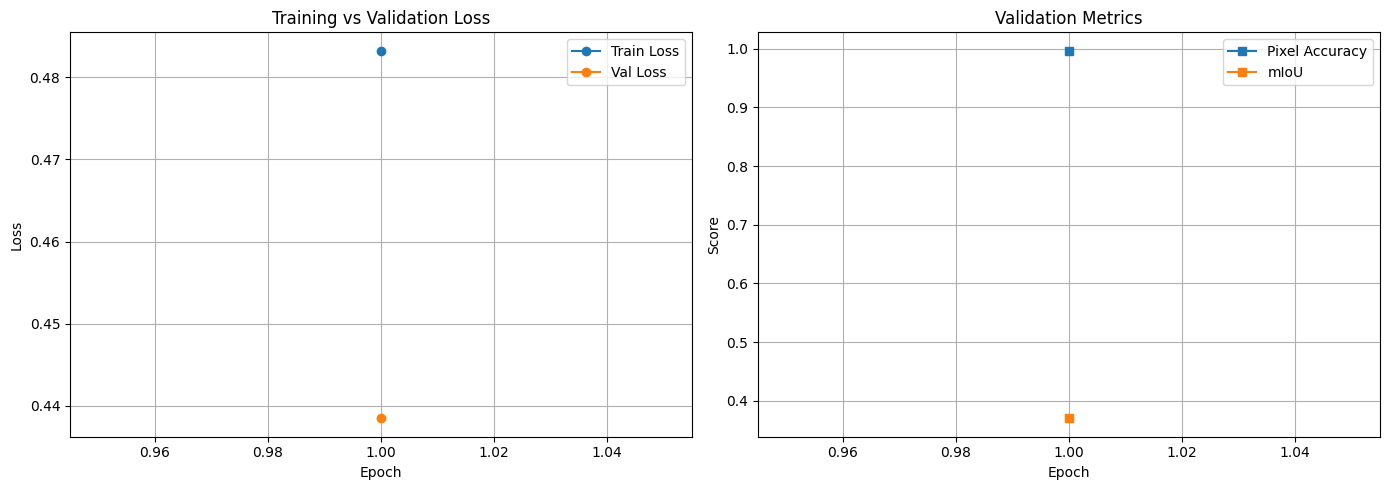

  Current Learning Rate: 0.000100

================ Epoch 2/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0092, Dice Loss: 0.8608, Total Loss: 0.4350
  [Train] Batch 2/121 - CE Loss: 0.0106, Dice Loss: 0.8599, Total Loss: 0.4353
  [Train] Batch 3/121 - CE Loss: 0.0076, Dice Loss: 0.8606, Total Loss: 0.4341
  [Train] Batch 4/121 - CE Loss: 0.0130, Dice Loss: 0.8590, Total Loss: 0.4360
  [Train] Batch 5/121 - CE Loss: 0.0157, Dice Loss: 0.8563, Total Loss: 0.4360
  [Train] Batch 6/121 - CE Loss: 0.0177, Dice Loss: 0.8614, Total Loss: 0.4395
  [Train] Batch 7/121 - CE Loss: 0.0164, Dice Loss: 0.8576, Total Loss: 0.4370
  [Train] Batch 8/121 - CE Loss: 0.0328, Dice Loss: 0.8543, Total Loss: 0.4436
  [Train] Batch 9/121 - CE Loss: 0.0122, Dice Loss: 0.8606, Total Loss: 0.4364
  [Train] Batch 10/121 - CE Loss: 0.0120, Dice Loss: 0.8595, Total Loss: 0.4358
  [Train] Batch 11/121 - CE Loss: 0.0124, Dice Loss: 0.8609, Total Loss: 0.4366
  [Train] Batch 12/121 - CE Loss: 0.0

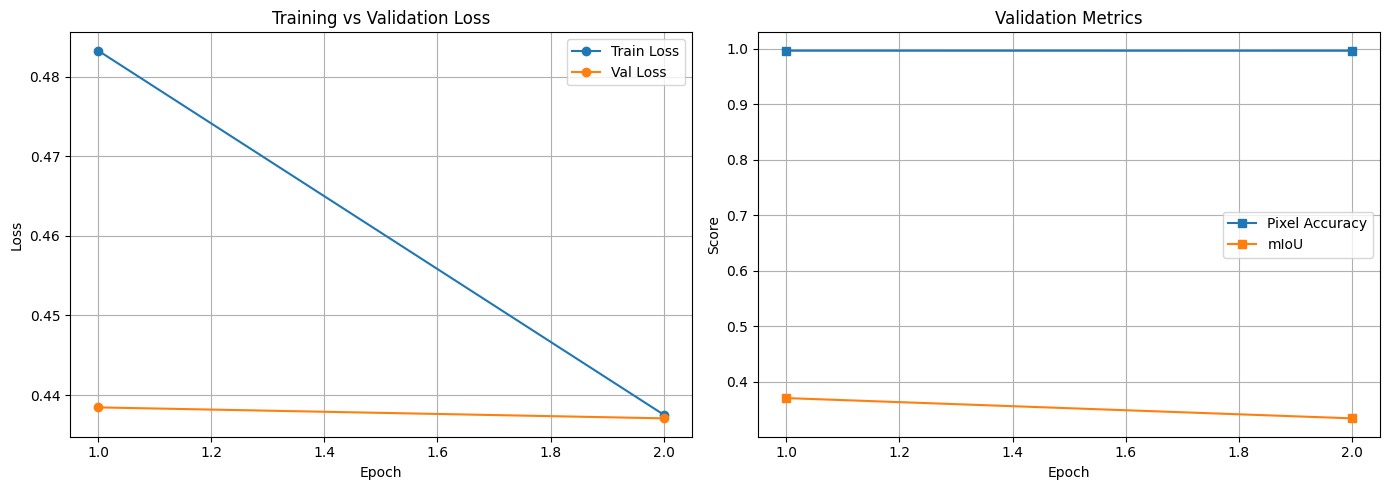

  Current Learning Rate: 0.000100

================ Epoch 3/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0095, Dice Loss: 0.8580, Total Loss: 0.4338
  [Train] Batch 2/121 - CE Loss: 0.0181, Dice Loss: 0.8569, Total Loss: 0.4375
  [Train] Batch 3/121 - CE Loss: 0.0199, Dice Loss: 0.8584, Total Loss: 0.4391
  [Train] Batch 4/121 - CE Loss: 0.0129, Dice Loss: 0.8522, Total Loss: 0.4325
  [Train] Batch 5/121 - CE Loss: 0.0103, Dice Loss: 0.8597, Total Loss: 0.4350
  [Train] Batch 6/121 - CE Loss: 0.0110, Dice Loss: 0.8592, Total Loss: 0.4351
  [Train] Batch 7/121 - CE Loss: 0.0145, Dice Loss: 0.8576, Total Loss: 0.4360
  [Train] Batch 8/121 - CE Loss: 0.0107, Dice Loss: 0.8581, Total Loss: 0.4344
  [Train] Batch 9/121 - CE Loss: 0.0122, Dice Loss: 0.8591, Total Loss: 0.4357
  [Train] Batch 10/121 - CE Loss: 0.0069, Dice Loss: 0.8600, Total Loss: 0.4334
  [Train] Batch 11/121 - CE Loss: 0.0260, Dice Loss: 0.8598, Total Loss: 0.4429
  [Train] Batch 12/121 - CE Loss: 0.0

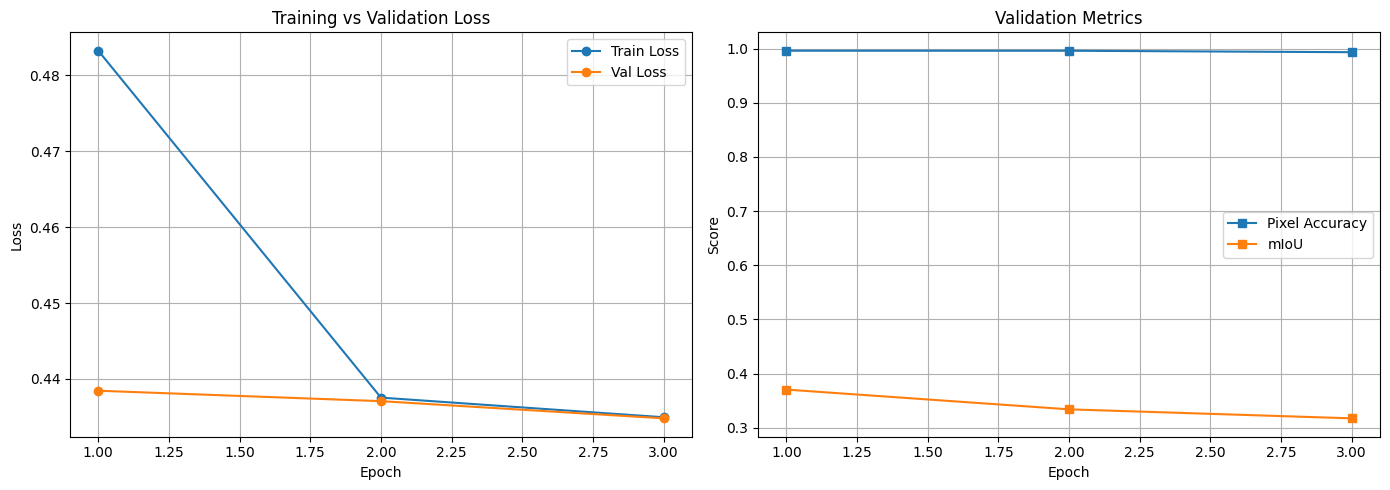

  Current Learning Rate: 0.000100

================ Epoch 4/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0148, Dice Loss: 0.8588, Total Loss: 0.4368
  [Train] Batch 2/121 - CE Loss: 0.0183, Dice Loss: 0.8560, Total Loss: 0.4371
  [Train] Batch 3/121 - CE Loss: 0.0108, Dice Loss: 0.8468, Total Loss: 0.4288
  [Train] Batch 4/121 - CE Loss: 0.0081, Dice Loss: 0.8343, Total Loss: 0.4212
  [Train] Batch 5/121 - CE Loss: 0.0147, Dice Loss: 0.8514, Total Loss: 0.4330
  [Train] Batch 6/121 - CE Loss: 0.0147, Dice Loss: 0.8535, Total Loss: 0.4341
  [Train] Batch 7/121 - CE Loss: 0.0127, Dice Loss: 0.8577, Total Loss: 0.4352
  [Train] Batch 8/121 - CE Loss: 0.0124, Dice Loss: 0.8440, Total Loss: 0.4282
  [Train] Batch 9/121 - CE Loss: 0.0192, Dice Loss: 0.8304, Total Loss: 0.4248
  [Train] Batch 10/121 - CE Loss: 0.0208, Dice Loss: 0.8568, Total Loss: 0.4388
  [Train] Batch 11/121 - CE Loss: 0.0117, Dice Loss: 0.8525, Total Loss: 0.4321
  [Train] Batch 12/121 - CE Loss: 0.0

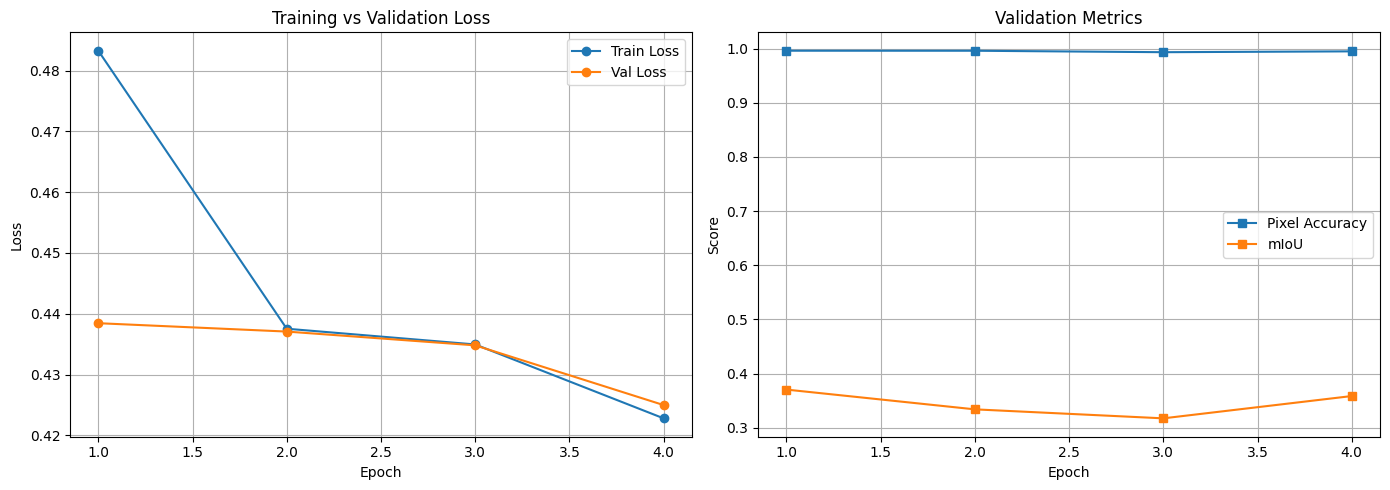

  Current Learning Rate: 0.000100

================ Epoch 5/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0143, Dice Loss: 0.8226, Total Loss: 0.4185
  [Train] Batch 2/121 - CE Loss: 0.0108, Dice Loss: 0.7805, Total Loss: 0.3957
  [Train] Batch 3/121 - CE Loss: 0.0152, Dice Loss: 0.8462, Total Loss: 0.4307
  [Train] Batch 4/121 - CE Loss: 0.0083, Dice Loss: 0.7680, Total Loss: 0.3882
  [Train] Batch 5/121 - CE Loss: 0.0145, Dice Loss: 0.7210, Total Loss: 0.3677
  [Train] Batch 6/121 - CE Loss: 0.0123, Dice Loss: 0.8215, Total Loss: 0.4169
  [Train] Batch 7/121 - CE Loss: 0.0183, Dice Loss: 0.8488, Total Loss: 0.4336
  [Train] Batch 8/121 - CE Loss: 0.0129, Dice Loss: 0.7453, Total Loss: 0.3791
  [Train] Batch 9/121 - CE Loss: 0.0125, Dice Loss: 0.7602, Total Loss: 0.3864
  [Train] Batch 10/121 - CE Loss: 0.0174, Dice Loss: 0.7836, Total Loss: 0.4005
  [Train] Batch 11/121 - CE Loss: 0.0168, Dice Loss: 0.8172, Total Loss: 0.4170
  [Train] Batch 12/121 - CE Loss: 0.0

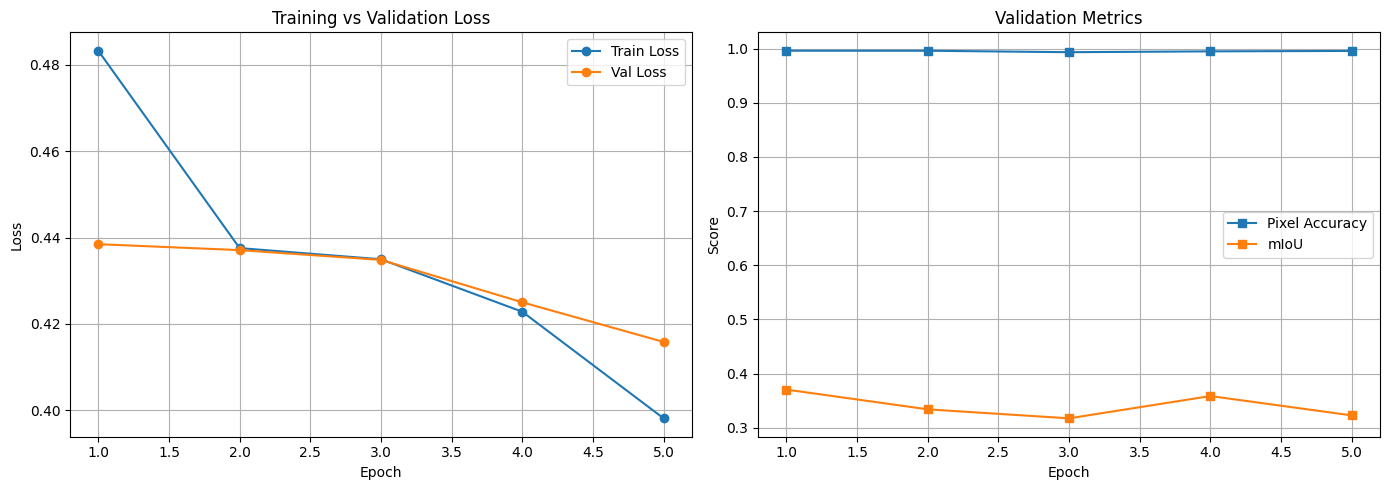

  Current Learning Rate: 0.000100

================ Epoch 6/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0140, Dice Loss: 0.7273, Total Loss: 0.3707
  [Train] Batch 2/121 - CE Loss: 0.0167, Dice Loss: 0.6896, Total Loss: 0.3531
  [Train] Batch 3/121 - CE Loss: 0.0121, Dice Loss: 0.7557, Total Loss: 0.3839
  [Train] Batch 4/121 - CE Loss: 0.0125, Dice Loss: 0.6813, Total Loss: 0.3469
  [Train] Batch 5/121 - CE Loss: 0.0147, Dice Loss: 0.7696, Total Loss: 0.3922
  [Train] Batch 6/121 - CE Loss: 0.0135, Dice Loss: 0.7468, Total Loss: 0.3802
  [Train] Batch 7/121 - CE Loss: 0.0195, Dice Loss: 0.8457, Total Loss: 0.4326
  [Train] Batch 8/121 - CE Loss: 0.0118, Dice Loss: 0.7394, Total Loss: 0.3756
  [Train] Batch 9/121 - CE Loss: 0.0088, Dice Loss: 0.7614, Total Loss: 0.3851
  [Train] Batch 10/121 - CE Loss: 0.0093, Dice Loss: 0.7616, Total Loss: 0.3854
  [Train] Batch 11/121 - CE Loss: 0.0100, Dice Loss: 0.8548, Total Loss: 0.4324
  [Train] Batch 12/121 - CE Loss: 0.0

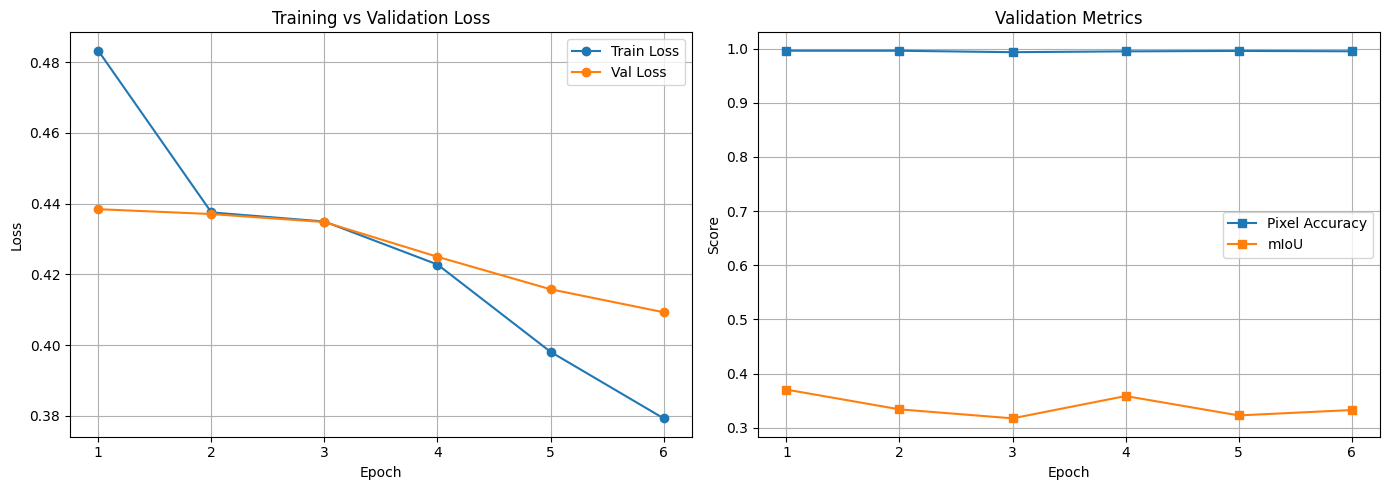

  Current Learning Rate: 0.000100

================ Epoch 7/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0085, Dice Loss: 0.6749, Total Loss: 0.3417
  [Train] Batch 2/121 - CE Loss: 0.0095, Dice Loss: 0.7286, Total Loss: 0.3691
  [Train] Batch 3/121 - CE Loss: 0.0097, Dice Loss: 0.7446, Total Loss: 0.3772
  [Train] Batch 4/121 - CE Loss: 0.0121, Dice Loss: 0.6987, Total Loss: 0.3554
  [Train] Batch 5/121 - CE Loss: 0.0120, Dice Loss: 0.7347, Total Loss: 0.3734
  [Train] Batch 6/121 - CE Loss: 0.0084, Dice Loss: 0.7709, Total Loss: 0.3897
  [Train] Batch 7/121 - CE Loss: 0.0190, Dice Loss: 0.8037, Total Loss: 0.4114
  [Train] Batch 8/121 - CE Loss: 0.0096, Dice Loss: 0.7442, Total Loss: 0.3769
  [Train] Batch 9/121 - CE Loss: 0.0124, Dice Loss: 0.7097, Total Loss: 0.3610
  [Train] Batch 10/121 - CE Loss: 0.0130, Dice Loss: 0.7427, Total Loss: 0.3778
  [Train] Batch 11/121 - CE Loss: 0.0105, Dice Loss: 0.6389, Total Loss: 0.3247
  [Train] Batch 12/121 - CE Loss: 0.0

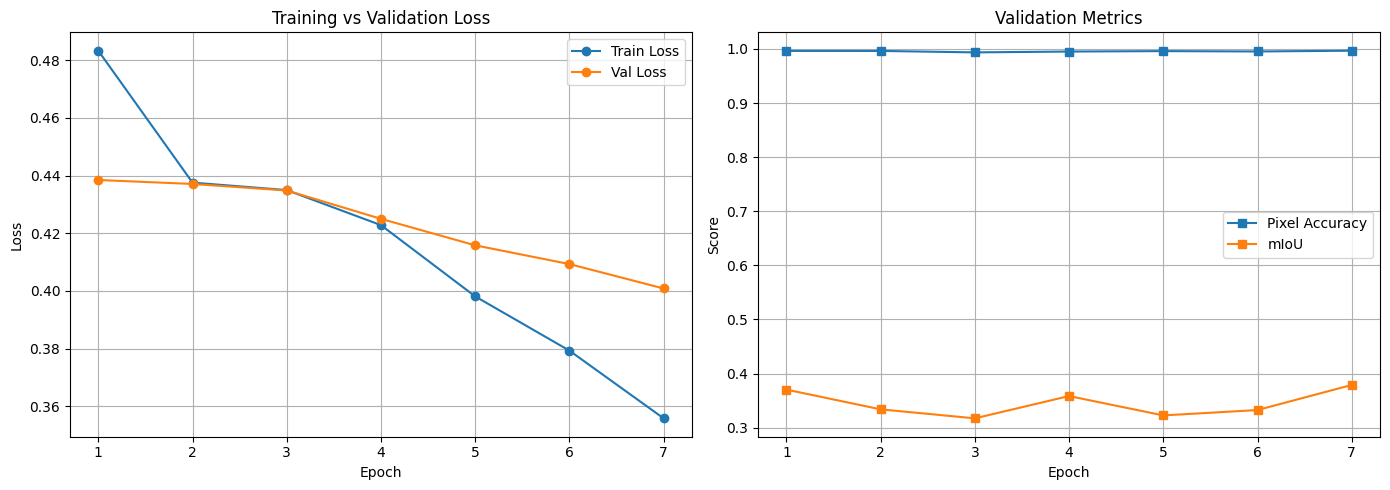

  Current Learning Rate: 0.000100

================ Epoch 8/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0050, Dice Loss: 0.5697, Total Loss: 0.2874
  [Train] Batch 2/121 - CE Loss: 0.0080, Dice Loss: 0.6790, Total Loss: 0.3435
  [Train] Batch 3/121 - CE Loss: 0.0171, Dice Loss: 0.7634, Total Loss: 0.3903
  [Train] Batch 4/121 - CE Loss: 0.0108, Dice Loss: 0.6493, Total Loss: 0.3301
  [Train] Batch 5/121 - CE Loss: 0.0092, Dice Loss: 0.6525, Total Loss: 0.3308
  [Train] Batch 6/121 - CE Loss: 0.0167, Dice Loss: 0.6366, Total Loss: 0.3267
  [Train] Batch 7/121 - CE Loss: 0.0074, Dice Loss: 0.7034, Total Loss: 0.3554
  [Train] Batch 8/121 - CE Loss: 0.0039, Dice Loss: 0.6323, Total Loss: 0.3181
  [Train] Batch 9/121 - CE Loss: 0.0076, Dice Loss: 0.6607, Total Loss: 0.3341
  [Train] Batch 10/121 - CE Loss: 0.0054, Dice Loss: 0.5431, Total Loss: 0.2743
  [Train] Batch 11/121 - CE Loss: 0.0083, Dice Loss: 0.7153, Total Loss: 0.3618
  [Train] Batch 12/121 - CE Loss: 0.0

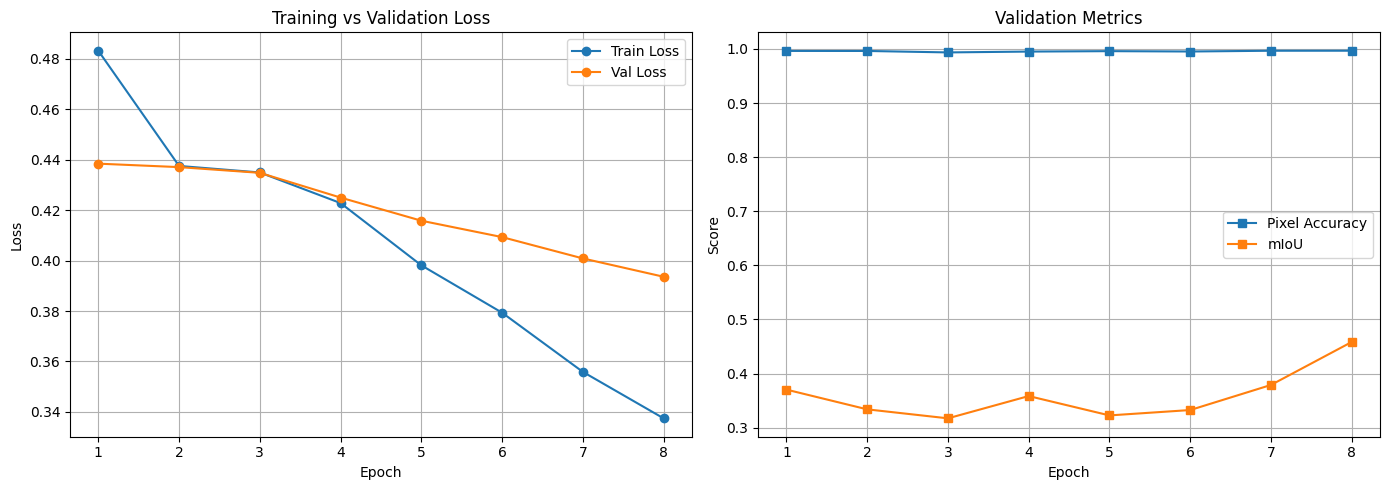

  Current Learning Rate: 0.000100

================ Epoch 9/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0050, Dice Loss: 0.6391, Total Loss: 0.3220
  [Train] Batch 2/121 - CE Loss: 0.0077, Dice Loss: 0.6933, Total Loss: 0.3505
  [Train] Batch 3/121 - CE Loss: 0.0167, Dice Loss: 0.6630, Total Loss: 0.3398
  [Train] Batch 4/121 - CE Loss: 0.0075, Dice Loss: 0.6933, Total Loss: 0.3504
  [Train] Batch 5/121 - CE Loss: 0.0078, Dice Loss: 0.6819, Total Loss: 0.3449
  [Train] Batch 6/121 - CE Loss: 0.0141, Dice Loss: 0.7457, Total Loss: 0.3799
  [Train] Batch 7/121 - CE Loss: 0.0116, Dice Loss: 0.6647, Total Loss: 0.3382
  [Train] Batch 8/121 - CE Loss: 0.0100, Dice Loss: 0.7184, Total Loss: 0.3642
  [Train] Batch 9/121 - CE Loss: 0.0095, Dice Loss: 0.6507, Total Loss: 0.3301
  [Train] Batch 10/121 - CE Loss: 0.0062, Dice Loss: 0.6149, Total Loss: 0.3106
  [Train] Batch 11/121 - CE Loss: 0.0072, Dice Loss: 0.6118, Total Loss: 0.3095
  [Train] Batch 12/121 - CE Loss: 0.0

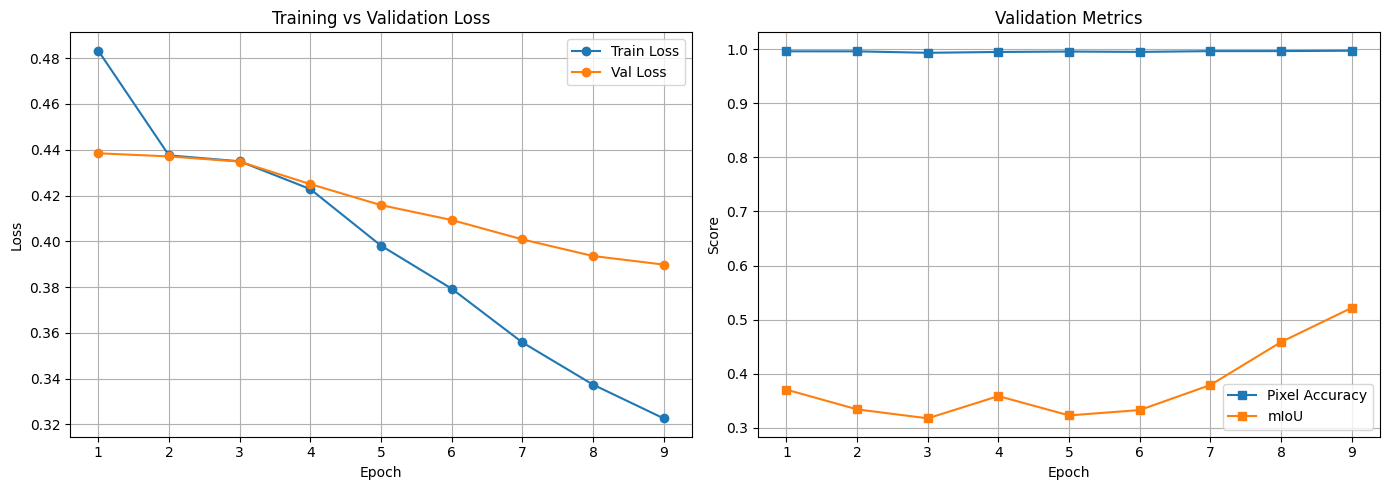

  Current Learning Rate: 0.000100

================ Epoch 10/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0075, Dice Loss: 0.7002, Total Loss: 0.3539
  [Train] Batch 2/121 - CE Loss: 0.0134, Dice Loss: 0.5325, Total Loss: 0.2729
  [Train] Batch 3/121 - CE Loss: 0.0128, Dice Loss: 0.6723, Total Loss: 0.3425
  [Train] Batch 4/121 - CE Loss: 0.0056, Dice Loss: 0.5256, Total Loss: 0.2656
  [Train] Batch 5/121 - CE Loss: 0.0088, Dice Loss: 0.6954, Total Loss: 0.3521
  [Train] Batch 6/121 - CE Loss: 0.0058, Dice Loss: 0.5926, Total Loss: 0.2992
  [Train] Batch 7/121 - CE Loss: 0.0066, Dice Loss: 0.5636, Total Loss: 0.2851
  [Train] Batch 8/121 - CE Loss: 0.0065, Dice Loss: 0.4791, Total Loss: 0.2428
  [Train] Batch 9/121 - CE Loss: 0.0072, Dice Loss: 0.6146, Total Loss: 0.3109
  [Train] Batch 10/121 - CE Loss: 0.0071, Dice Loss: 0.6805, Total Loss: 0.3438
  [Train] Batch 11/121 - CE Loss: 0.0081, Dice Loss: 0.5984, Total Loss: 0.3032
  [Train] Batch 12/121 - CE Loss: 0.

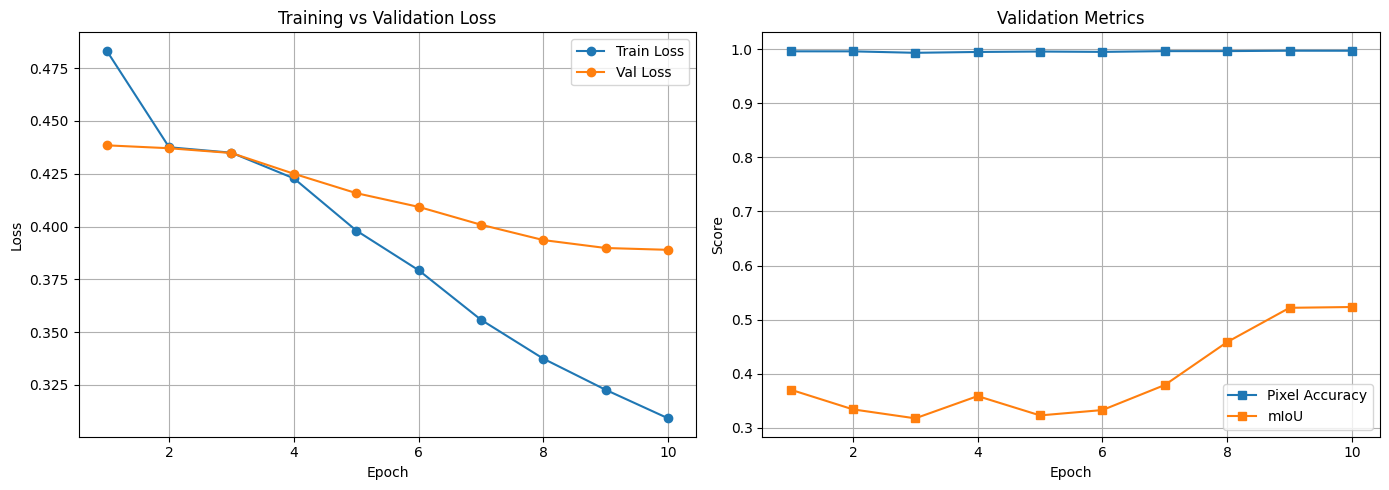

  Current Learning Rate: 0.000100

================ Epoch 11/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0046, Dice Loss: 0.5530, Total Loss: 0.2788
  [Train] Batch 2/121 - CE Loss: 0.0080, Dice Loss: 0.7000, Total Loss: 0.3540
  [Train] Batch 3/121 - CE Loss: 0.0073, Dice Loss: 0.5825, Total Loss: 0.2949
  [Train] Batch 4/121 - CE Loss: 0.0072, Dice Loss: 0.6073, Total Loss: 0.3073
  [Train] Batch 5/121 - CE Loss: 0.0058, Dice Loss: 0.4614, Total Loss: 0.2336
  [Train] Batch 6/121 - CE Loss: 0.0063, Dice Loss: 0.6979, Total Loss: 0.3521
  [Train] Batch 7/121 - CE Loss: 0.0045, Dice Loss: 0.5971, Total Loss: 0.3008
  [Train] Batch 8/121 - CE Loss: 0.0113, Dice Loss: 0.5724, Total Loss: 0.2918
  [Train] Batch 9/121 - CE Loss: 0.0048, Dice Loss: 0.5815, Total Loss: 0.2931
  [Train] Batch 10/121 - CE Loss: 0.0071, Dice Loss: 0.5224, Total Loss: 0.2648
  [Train] Batch 11/121 - CE Loss: 0.0061, Dice Loss: 0.6145, Total Loss: 0.3103
  [Train] Batch 12/121 - CE Loss: 0.

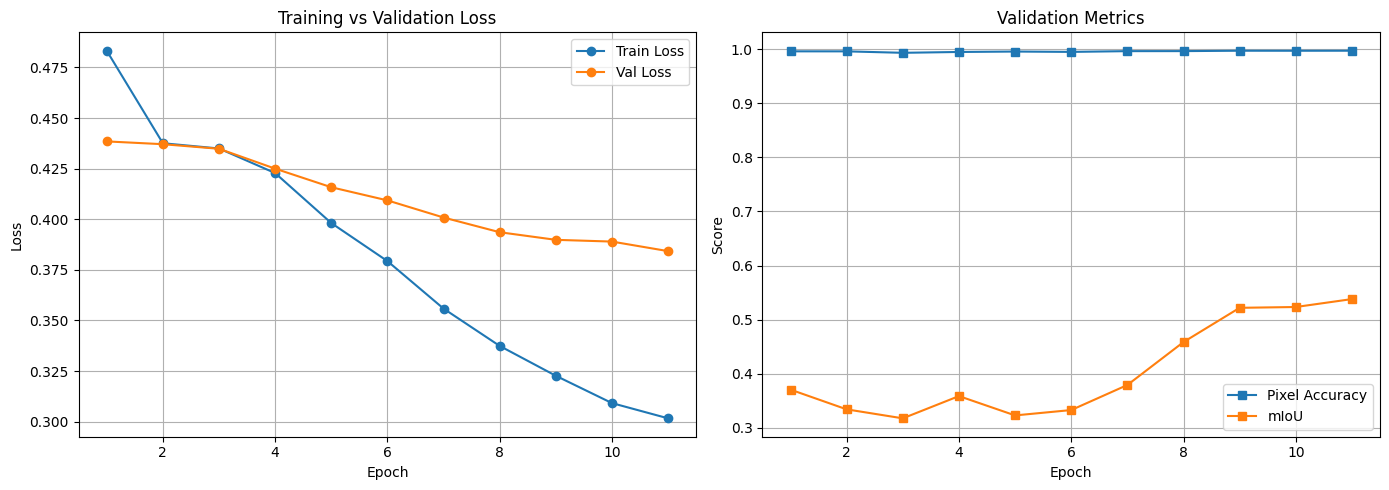

  Current Learning Rate: 0.000100

================ Epoch 12/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0073, Dice Loss: 0.5590, Total Loss: 0.2831
  [Train] Batch 2/121 - CE Loss: 0.0099, Dice Loss: 0.4678, Total Loss: 0.2389
  [Train] Batch 3/121 - CE Loss: 0.0060, Dice Loss: 0.5832, Total Loss: 0.2946
  [Train] Batch 4/121 - CE Loss: 0.0093, Dice Loss: 0.6842, Total Loss: 0.3468
  [Train] Batch 5/121 - CE Loss: 0.0064, Dice Loss: 0.5710, Total Loss: 0.2887
  [Train] Batch 6/121 - CE Loss: 0.0109, Dice Loss: 0.6746, Total Loss: 0.3428
  [Train] Batch 7/121 - CE Loss: 0.0069, Dice Loss: 0.5925, Total Loss: 0.2997
  [Train] Batch 8/121 - CE Loss: 0.0039, Dice Loss: 0.5626, Total Loss: 0.2833
  [Train] Batch 9/121 - CE Loss: 0.0123, Dice Loss: 0.6400, Total Loss: 0.3261
  [Train] Batch 10/121 - CE Loss: 0.0106, Dice Loss: 0.5848, Total Loss: 0.2977
  [Train] Batch 11/121 - CE Loss: 0.0117, Dice Loss: 0.4854, Total Loss: 0.2485
  [Train] Batch 12/121 - CE Loss: 0.

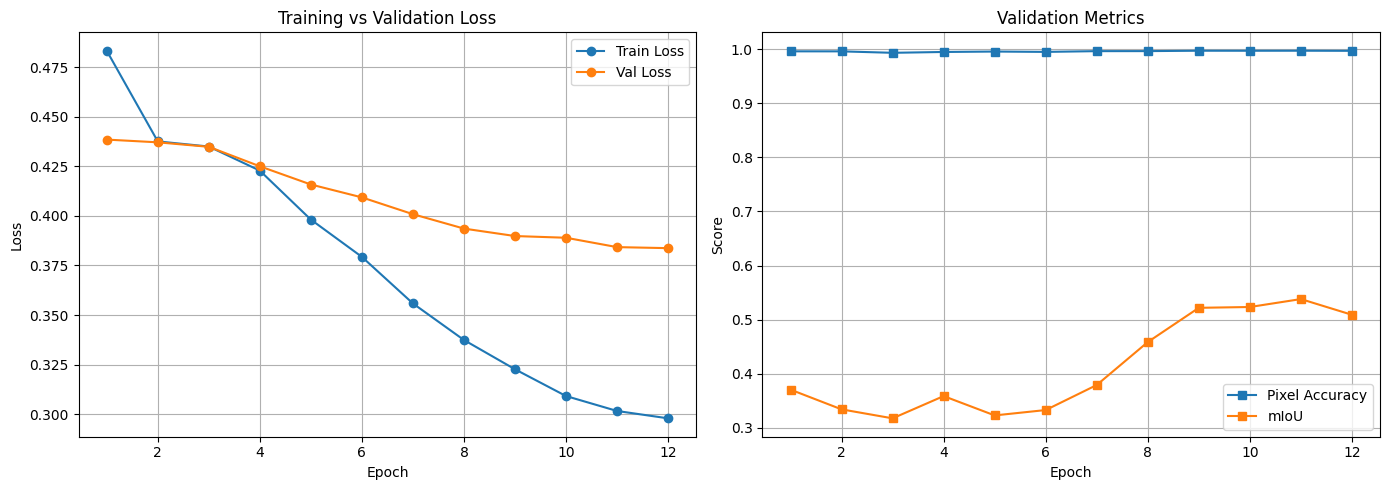

  Current Learning Rate: 0.000100

================ Epoch 13/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0068, Dice Loss: 0.5871, Total Loss: 0.2969
  [Train] Batch 2/121 - CE Loss: 0.0047, Dice Loss: 0.5587, Total Loss: 0.2817
  [Train] Batch 3/121 - CE Loss: 0.0105, Dice Loss: 0.5560, Total Loss: 0.2832
  [Train] Batch 4/121 - CE Loss: 0.0119, Dice Loss: 0.6794, Total Loss: 0.3456
  [Train] Batch 5/121 - CE Loss: 0.0105, Dice Loss: 0.5995, Total Loss: 0.3050
  [Train] Batch 6/121 - CE Loss: 0.0098, Dice Loss: 0.5925, Total Loss: 0.3012
  [Train] Batch 7/121 - CE Loss: 0.0087, Dice Loss: 0.6243, Total Loss: 0.3165
  [Train] Batch 8/121 - CE Loss: 0.0043, Dice Loss: 0.6805, Total Loss: 0.3424
  [Train] Batch 9/121 - CE Loss: 0.0101, Dice Loss: 0.6130, Total Loss: 0.3116
  [Train] Batch 10/121 - CE Loss: 0.0030, Dice Loss: 0.6746, Total Loss: 0.3388
  [Train] Batch 11/121 - CE Loss: 0.0052, Dice Loss: 0.6529, Total Loss: 0.3290
  [Train] Batch 12/121 - CE Loss: 0.

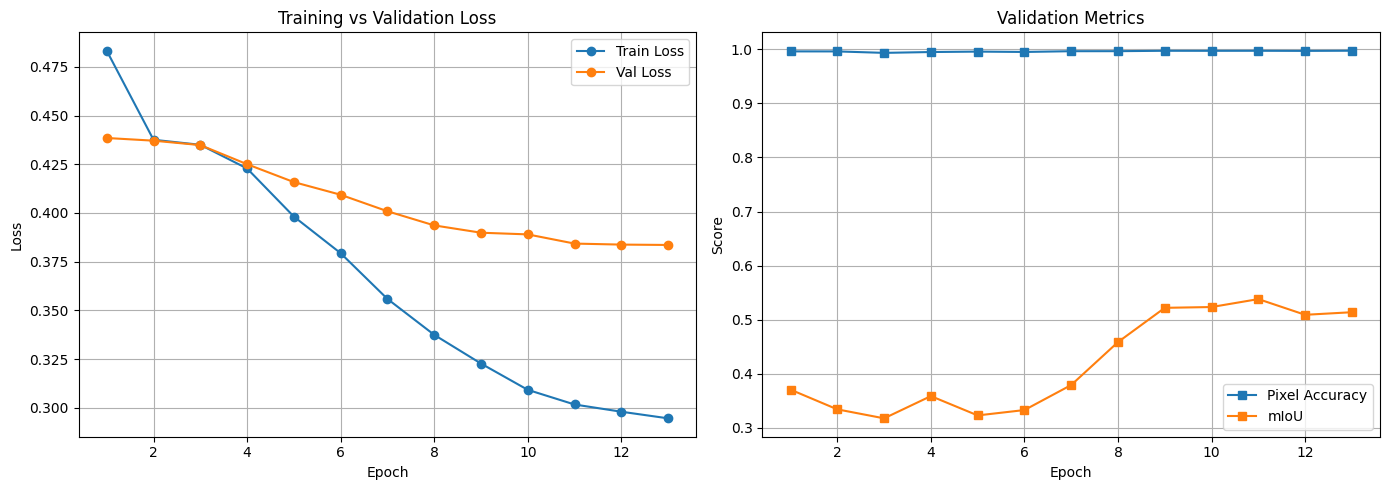

  Current Learning Rate: 0.000100

================ Epoch 14/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0142, Dice Loss: 0.5405, Total Loss: 0.2774
  [Train] Batch 2/121 - CE Loss: 0.0067, Dice Loss: 0.6668, Total Loss: 0.3368
  [Train] Batch 3/121 - CE Loss: 0.0050, Dice Loss: 0.5458, Total Loss: 0.2754
  [Train] Batch 4/121 - CE Loss: 0.0077, Dice Loss: 0.6804, Total Loss: 0.3440
  [Train] Batch 5/121 - CE Loss: 0.0028, Dice Loss: 0.5497, Total Loss: 0.2762
  [Train] Batch 6/121 - CE Loss: 0.0091, Dice Loss: 0.6948, Total Loss: 0.3519
  [Train] Batch 7/121 - CE Loss: 0.0065, Dice Loss: 0.6538, Total Loss: 0.3302
  [Train] Batch 8/121 - CE Loss: 0.0115, Dice Loss: 0.6876, Total Loss: 0.3496
  [Train] Batch 9/121 - CE Loss: 0.0057, Dice Loss: 0.5747, Total Loss: 0.2902
  [Train] Batch 10/121 - CE Loss: 0.0047, Dice Loss: 0.5367, Total Loss: 0.2707
  [Train] Batch 11/121 - CE Loss: 0.0047, Dice Loss: 0.5460, Total Loss: 0.2754
  [Train] Batch 12/121 - CE Loss: 0.

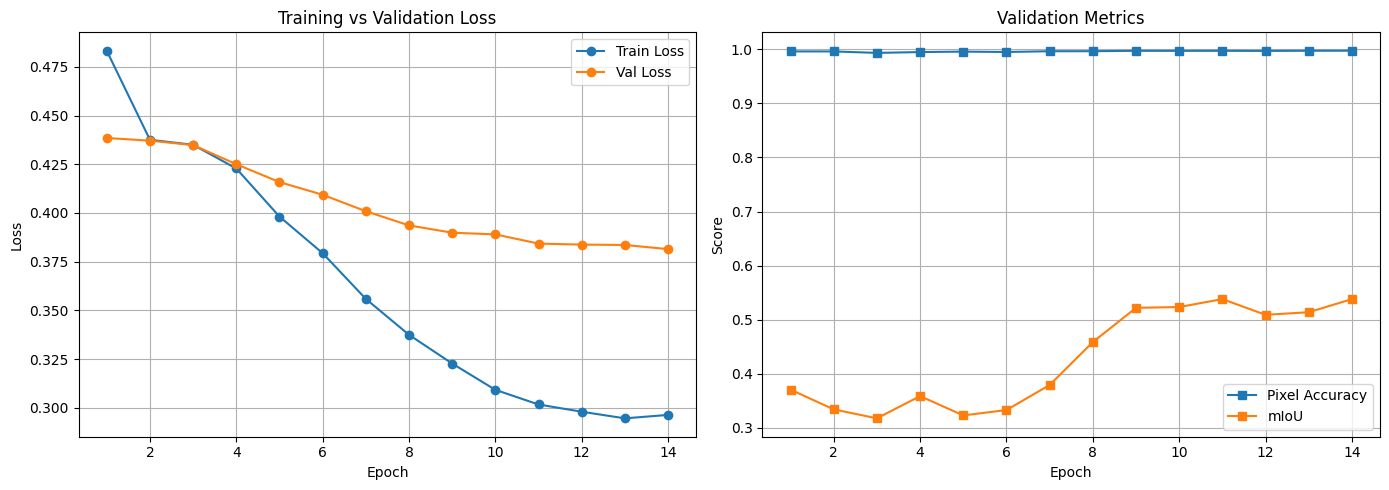

  Current Learning Rate: 0.000100

================ Epoch 15/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0118, Dice Loss: 0.6150, Total Loss: 0.3134
  [Train] Batch 2/121 - CE Loss: 0.0067, Dice Loss: 0.5464, Total Loss: 0.2766
  [Train] Batch 3/121 - CE Loss: 0.0051, Dice Loss: 0.4295, Total Loss: 0.2173
  [Train] Batch 4/121 - CE Loss: 0.0076, Dice Loss: 0.6407, Total Loss: 0.3242
  [Train] Batch 5/121 - CE Loss: 0.0111, Dice Loss: 0.4884, Total Loss: 0.2498
  [Train] Batch 6/121 - CE Loss: 0.0074, Dice Loss: 0.4691, Total Loss: 0.2383
  [Train] Batch 7/121 - CE Loss: 0.0077, Dice Loss: 0.6536, Total Loss: 0.3307
  [Train] Batch 8/121 - CE Loss: 0.0039, Dice Loss: 0.5336, Total Loss: 0.2687
  [Train] Batch 9/121 - CE Loss: 0.0043, Dice Loss: 0.5694, Total Loss: 0.2868
  [Train] Batch 10/121 - CE Loss: 0.0061, Dice Loss: 0.4416, Total Loss: 0.2238
  [Train] Batch 11/121 - CE Loss: 0.0039, Dice Loss: 0.6081, Total Loss: 0.3060
  [Train] Batch 12/121 - CE Loss: 0.

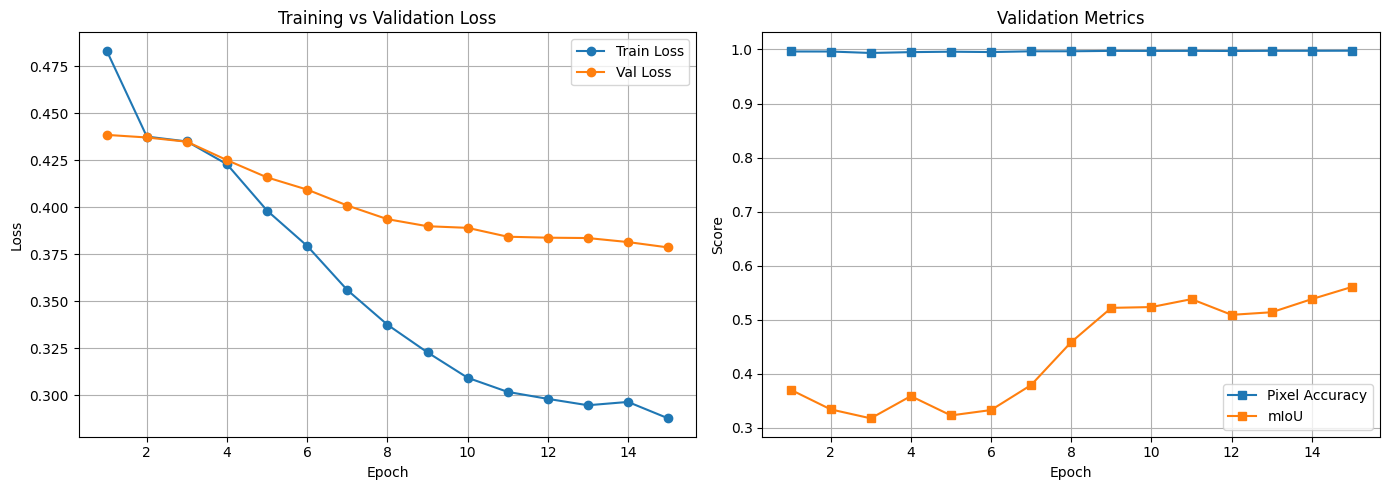

  Current Learning Rate: 0.000100

================ Epoch 16/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0081, Dice Loss: 0.5221, Total Loss: 0.2651
  [Train] Batch 2/121 - CE Loss: 0.0049, Dice Loss: 0.5793, Total Loss: 0.2921
  [Train] Batch 3/121 - CE Loss: 0.0044, Dice Loss: 0.5121, Total Loss: 0.2583
  [Train] Batch 4/121 - CE Loss: 0.0101, Dice Loss: 0.4928, Total Loss: 0.2514
  [Train] Batch 5/121 - CE Loss: 0.0043, Dice Loss: 0.4881, Total Loss: 0.2462
  [Train] Batch 6/121 - CE Loss: 0.0048, Dice Loss: 0.5697, Total Loss: 0.2872
  [Train] Batch 7/121 - CE Loss: 0.0069, Dice Loss: 0.6557, Total Loss: 0.3313
  [Train] Batch 8/121 - CE Loss: 0.0100, Dice Loss: 0.7632, Total Loss: 0.3866
  [Train] Batch 9/121 - CE Loss: 0.0058, Dice Loss: 0.6476, Total Loss: 0.3267
  [Train] Batch 10/121 - CE Loss: 0.0036, Dice Loss: 0.5374, Total Loss: 0.2705
  [Train] Batch 11/121 - CE Loss: 0.0046, Dice Loss: 0.5254, Total Loss: 0.2650
  [Train] Batch 12/121 - CE Loss: 0.

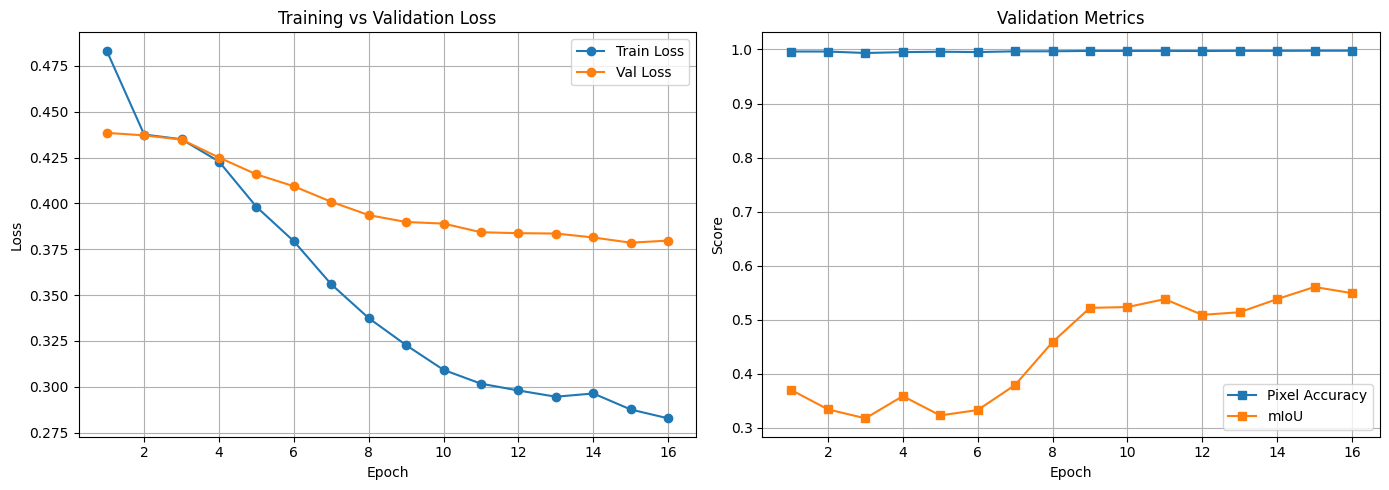

  Current Learning Rate: 0.000100

================ Epoch 17/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0054, Dice Loss: 0.6489, Total Loss: 0.3271
  [Train] Batch 2/121 - CE Loss: 0.0130, Dice Loss: 0.4842, Total Loss: 0.2486
  [Train] Batch 3/121 - CE Loss: 0.0041, Dice Loss: 0.5510, Total Loss: 0.2776
  [Train] Batch 4/121 - CE Loss: 0.0071, Dice Loss: 0.6875, Total Loss: 0.3473
  [Train] Batch 5/121 - CE Loss: 0.0041, Dice Loss: 0.5589, Total Loss: 0.2815
  [Train] Batch 6/121 - CE Loss: 0.0066, Dice Loss: 0.6516, Total Loss: 0.3291
  [Train] Batch 7/121 - CE Loss: 0.0068, Dice Loss: 0.5667, Total Loss: 0.2867
  [Train] Batch 8/121 - CE Loss: 0.0056, Dice Loss: 0.5152, Total Loss: 0.2604
  [Train] Batch 9/121 - CE Loss: 0.0044, Dice Loss: 0.4702, Total Loss: 0.2373
  [Train] Batch 10/121 - CE Loss: 0.0079, Dice Loss: 0.5561, Total Loss: 0.2820
  [Train] Batch 11/121 - CE Loss: 0.0056, Dice Loss: 0.6650, Total Loss: 0.3353
  [Train] Batch 12/121 - CE Loss: 0.

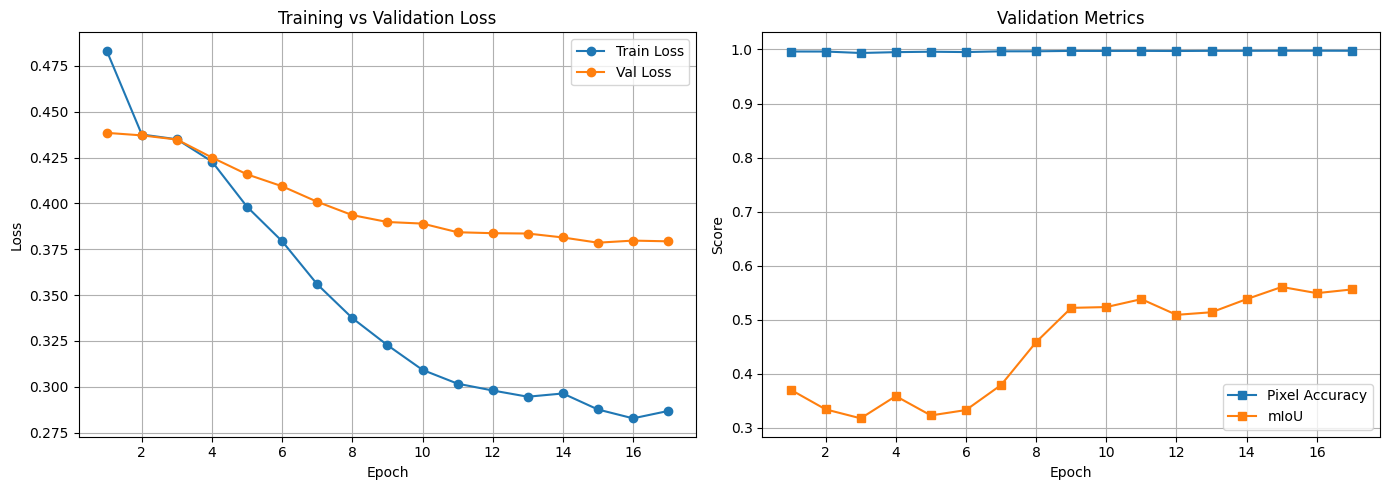

  Current Learning Rate: 0.000100

================ Epoch 18/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0033, Dice Loss: 0.6444, Total Loss: 0.3238
  [Train] Batch 2/121 - CE Loss: 0.0105, Dice Loss: 0.6798, Total Loss: 0.3452
  [Train] Batch 3/121 - CE Loss: 0.0042, Dice Loss: 0.5309, Total Loss: 0.2676
  [Train] Batch 4/121 - CE Loss: 0.0057, Dice Loss: 0.5215, Total Loss: 0.2636
  [Train] Batch 5/121 - CE Loss: 0.0113, Dice Loss: 0.5249, Total Loss: 0.2681
  [Train] Batch 6/121 - CE Loss: 0.0026, Dice Loss: 0.5237, Total Loss: 0.2632
  [Train] Batch 7/121 - CE Loss: 0.0072, Dice Loss: 0.4318, Total Loss: 0.2195
  [Train] Batch 8/121 - CE Loss: 0.0091, Dice Loss: 0.5720, Total Loss: 0.2905
  [Train] Batch 9/121 - CE Loss: 0.0073, Dice Loss: 0.7003, Total Loss: 0.3538
  [Train] Batch 10/121 - CE Loss: 0.0024, Dice Loss: 0.6405, Total Loss: 0.3215
  [Train] Batch 11/121 - CE Loss: 0.0059, Dice Loss: 0.5301, Total Loss: 0.2680
  [Train] Batch 12/121 - CE Loss: 0.

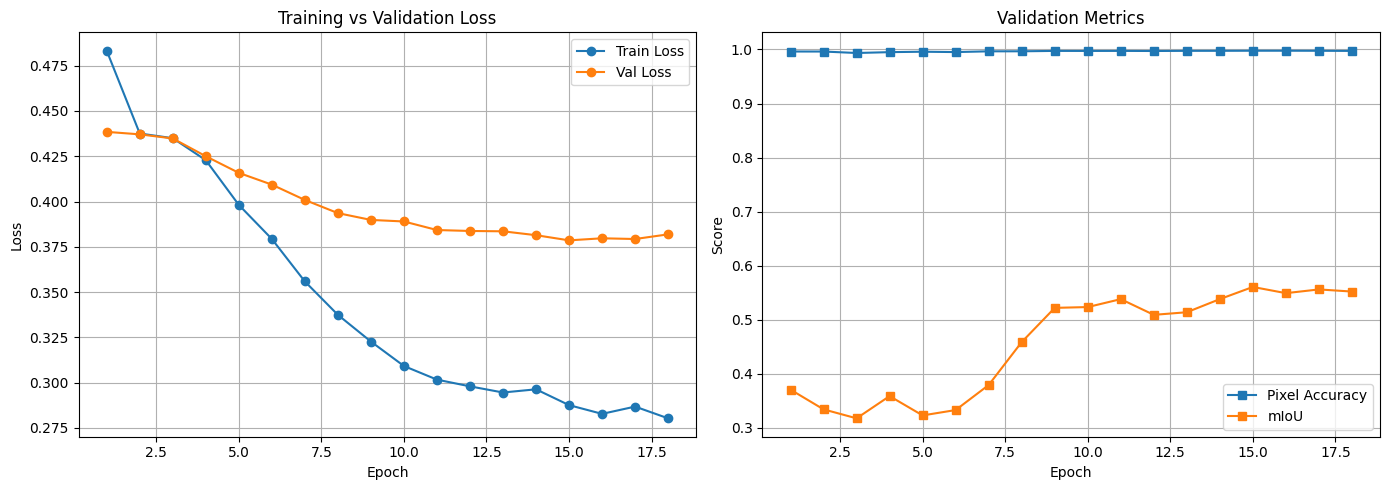

  Current Learning Rate: 0.000100

================ Epoch 19/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0117, Dice Loss: 0.5794, Total Loss: 0.2956
  [Train] Batch 2/121 - CE Loss: 0.0043, Dice Loss: 0.5662, Total Loss: 0.2853
  [Train] Batch 3/121 - CE Loss: 0.0064, Dice Loss: 0.5469, Total Loss: 0.2767
  [Train] Batch 4/121 - CE Loss: 0.0076, Dice Loss: 0.4980, Total Loss: 0.2528
  [Train] Batch 5/121 - CE Loss: 0.0086, Dice Loss: 0.5429, Total Loss: 0.2758
  [Train] Batch 6/121 - CE Loss: 0.0054, Dice Loss: 0.6549, Total Loss: 0.3301
  [Train] Batch 7/121 - CE Loss: 0.0037, Dice Loss: 0.5389, Total Loss: 0.2713
  [Train] Batch 8/121 - CE Loss: 0.0069, Dice Loss: 0.5877, Total Loss: 0.2973
  [Train] Batch 9/121 - CE Loss: 0.0037, Dice Loss: 0.5438, Total Loss: 0.2737
  [Train] Batch 10/121 - CE Loss: 0.0034, Dice Loss: 0.5518, Total Loss: 0.2776
  [Train] Batch 11/121 - CE Loss: 0.0054, Dice Loss: 0.5345, Total Loss: 0.2700
  [Train] Batch 12/121 - CE Loss: 0.

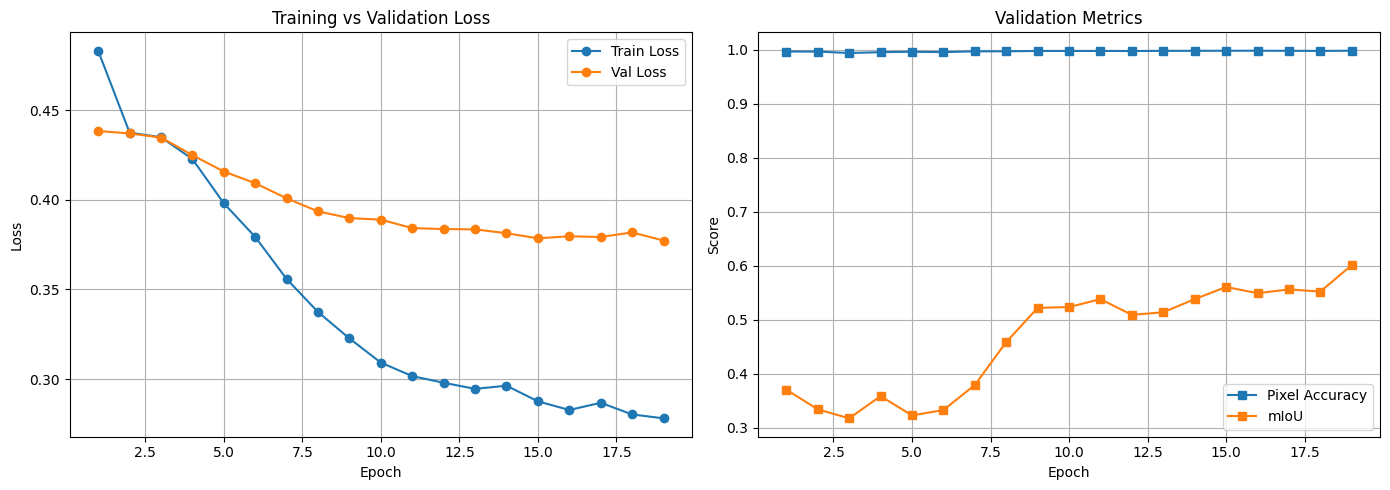

  Current Learning Rate: 0.000100

================ Epoch 20/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0111, Dice Loss: 0.5505, Total Loss: 0.2808
  [Train] Batch 2/121 - CE Loss: 0.0062, Dice Loss: 0.4137, Total Loss: 0.2100
  [Train] Batch 3/121 - CE Loss: 0.0028, Dice Loss: 0.6320, Total Loss: 0.3174
  [Train] Batch 4/121 - CE Loss: 0.0079, Dice Loss: 0.6187, Total Loss: 0.3133
  [Train] Batch 5/121 - CE Loss: 0.0062, Dice Loss: 0.4674, Total Loss: 0.2368
  [Train] Batch 6/121 - CE Loss: 0.0047, Dice Loss: 0.6513, Total Loss: 0.3280
  [Train] Batch 7/121 - CE Loss: 0.0050, Dice Loss: 0.6555, Total Loss: 0.3302
  [Train] Batch 8/121 - CE Loss: 0.0071, Dice Loss: 0.5594, Total Loss: 0.2832
  [Train] Batch 9/121 - CE Loss: 0.0047, Dice Loss: 0.4854, Total Loss: 0.2450
  [Train] Batch 10/121 - CE Loss: 0.0026, Dice Loss: 0.4440, Total Loss: 0.2233
  [Train] Batch 11/121 - CE Loss: 0.0089, Dice Loss: 0.6111, Total Loss: 0.3100
  [Train] Batch 12/121 - CE Loss: 0.

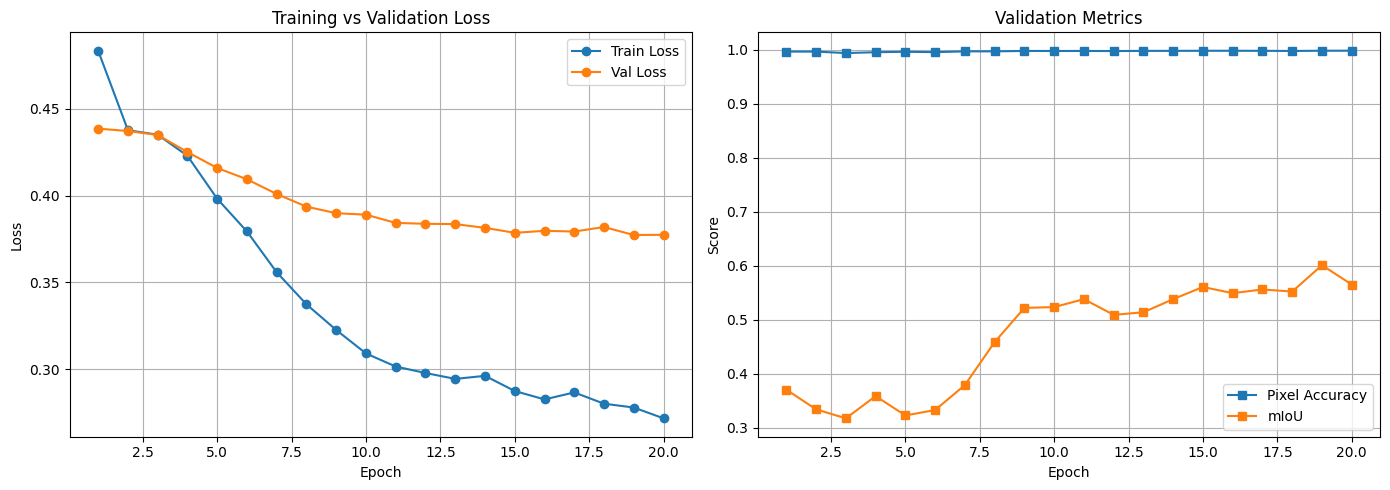

  Current Learning Rate: 0.000100

================ Epoch 21/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0028, Dice Loss: 0.5412, Total Loss: 0.2720
  [Train] Batch 2/121 - CE Loss: 0.0056, Dice Loss: 0.5131, Total Loss: 0.2593
  [Train] Batch 3/121 - CE Loss: 0.0046, Dice Loss: 0.4243, Total Loss: 0.2144
  [Train] Batch 4/121 - CE Loss: 0.0054, Dice Loss: 0.5215, Total Loss: 0.2635
  [Train] Batch 5/121 - CE Loss: 0.0054, Dice Loss: 0.5270, Total Loss: 0.2662
  [Train] Batch 6/121 - CE Loss: 0.0037, Dice Loss: 0.5244, Total Loss: 0.2640
  [Train] Batch 7/121 - CE Loss: 0.0045, Dice Loss: 0.5481, Total Loss: 0.2763
  [Train] Batch 8/121 - CE Loss: 0.0034, Dice Loss: 0.5293, Total Loss: 0.2663
  [Train] Batch 9/121 - CE Loss: 0.0074, Dice Loss: 0.6386, Total Loss: 0.3230
  [Train] Batch 10/121 - CE Loss: 0.0032, Dice Loss: 0.4317, Total Loss: 0.2174
  [Train] Batch 11/121 - CE Loss: 0.0051, Dice Loss: 0.4249, Total Loss: 0.2150
  [Train] Batch 12/121 - CE Loss: 0.

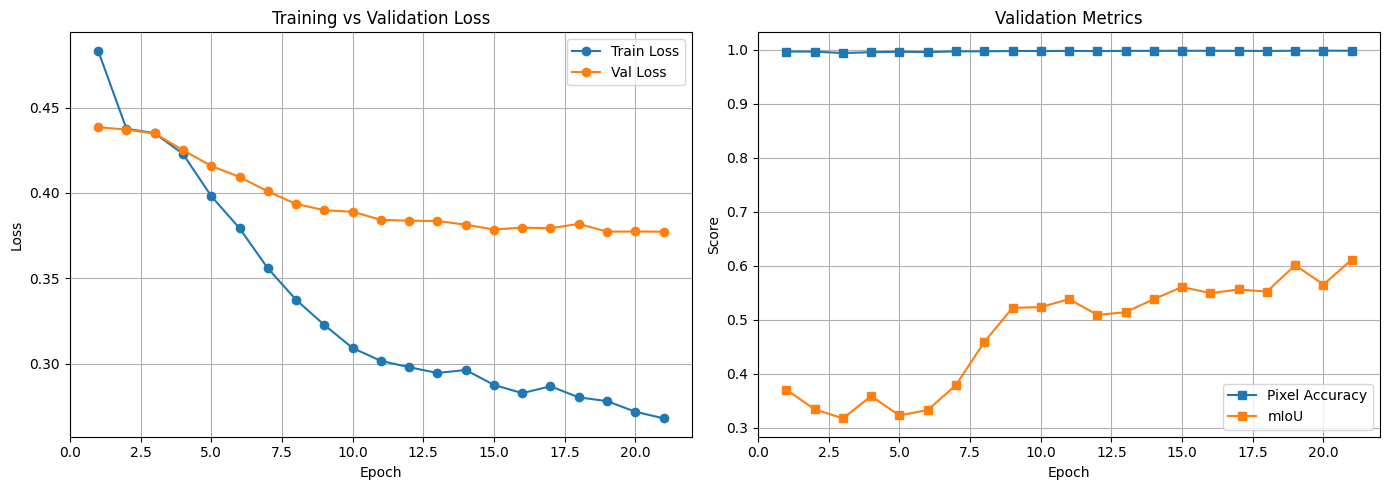

  Current Learning Rate: 0.000100

================ Epoch 22/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0052, Dice Loss: 0.5439, Total Loss: 0.2746
  [Train] Batch 2/121 - CE Loss: 0.0110, Dice Loss: 0.6106, Total Loss: 0.3108
  [Train] Batch 3/121 - CE Loss: 0.0068, Dice Loss: 0.5675, Total Loss: 0.2871
  [Train] Batch 4/121 - CE Loss: 0.0066, Dice Loss: 0.4636, Total Loss: 0.2351
  [Train] Batch 5/121 - CE Loss: 0.0047, Dice Loss: 0.5323, Total Loss: 0.2685
  [Train] Batch 6/121 - CE Loss: 0.0077, Dice Loss: 0.4701, Total Loss: 0.2389
  [Train] Batch 7/121 - CE Loss: 0.0052, Dice Loss: 0.4200, Total Loss: 0.2126
  [Train] Batch 8/121 - CE Loss: 0.0030, Dice Loss: 0.5401, Total Loss: 0.2716
  [Train] Batch 9/121 - CE Loss: 0.0103, Dice Loss: 0.5712, Total Loss: 0.2907
  [Train] Batch 10/121 - CE Loss: 0.0148, Dice Loss: 0.5461, Total Loss: 0.2805
  [Train] Batch 11/121 - CE Loss: 0.0032, Dice Loss: 0.5338, Total Loss: 0.2685
  [Train] Batch 12/121 - CE Loss: 0.

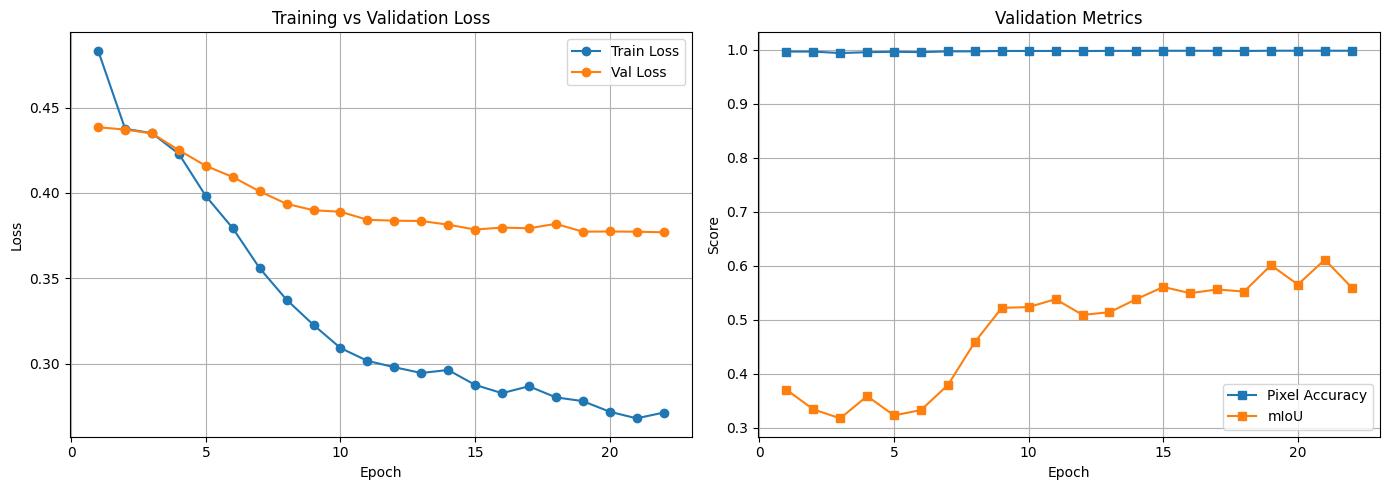

  Current Learning Rate: 0.000100

================ Epoch 23/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0040, Dice Loss: 0.6301, Total Loss: 0.3171
  [Train] Batch 2/121 - CE Loss: 0.0052, Dice Loss: 0.5254, Total Loss: 0.2653
  [Train] Batch 3/121 - CE Loss: 0.0084, Dice Loss: 0.6526, Total Loss: 0.3305
  [Train] Batch 4/121 - CE Loss: 0.0094, Dice Loss: 0.6607, Total Loss: 0.3351
  [Train] Batch 5/121 - CE Loss: 0.0077, Dice Loss: 0.5387, Total Loss: 0.2732
  [Train] Batch 6/121 - CE Loss: 0.0054, Dice Loss: 0.6271, Total Loss: 0.3162
  [Train] Batch 7/121 - CE Loss: 0.0057, Dice Loss: 0.6336, Total Loss: 0.3196
  [Train] Batch 8/121 - CE Loss: 0.0039, Dice Loss: 0.5493, Total Loss: 0.2766
  [Train] Batch 9/121 - CE Loss: 0.0032, Dice Loss: 0.6293, Total Loss: 0.3162
  [Train] Batch 10/121 - CE Loss: 0.0045, Dice Loss: 0.5465, Total Loss: 0.2755
  [Train] Batch 11/121 - CE Loss: 0.0058, Dice Loss: 0.4545, Total Loss: 0.2301
  [Train] Batch 12/121 - CE Loss: 0.

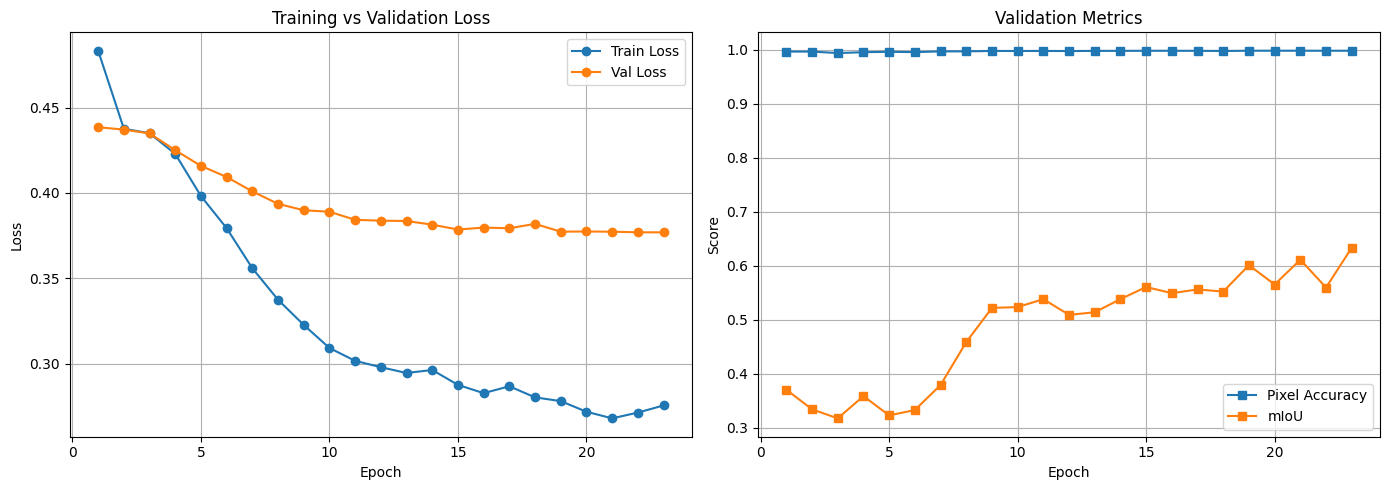

  Current Learning Rate: 0.000100

================ Epoch 24/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0026, Dice Loss: 0.5196, Total Loss: 0.2611
  [Train] Batch 2/121 - CE Loss: 0.0068, Dice Loss: 0.5848, Total Loss: 0.2958
  [Train] Batch 3/121 - CE Loss: 0.0043, Dice Loss: 0.3955, Total Loss: 0.1999
  [Train] Batch 4/121 - CE Loss: 0.0089, Dice Loss: 0.5410, Total Loss: 0.2749
  [Train] Batch 5/121 - CE Loss: 0.0068, Dice Loss: 0.5304, Total Loss: 0.2686
  [Train] Batch 6/121 - CE Loss: 0.0069, Dice Loss: 0.5210, Total Loss: 0.2639
  [Train] Batch 7/121 - CE Loss: 0.0058, Dice Loss: 0.5359, Total Loss: 0.2709
  [Train] Batch 8/121 - CE Loss: 0.0049, Dice Loss: 0.5456, Total Loss: 0.2752
  [Train] Batch 9/121 - CE Loss: 0.0047, Dice Loss: 0.5469, Total Loss: 0.2758
  [Train] Batch 10/121 - CE Loss: 0.0043, Dice Loss: 0.4340, Total Loss: 0.2192
  [Train] Batch 11/121 - CE Loss: 0.0026, Dice Loss: 0.6276, Total Loss: 0.3151
  [Train] Batch 12/121 - CE Loss: 0.

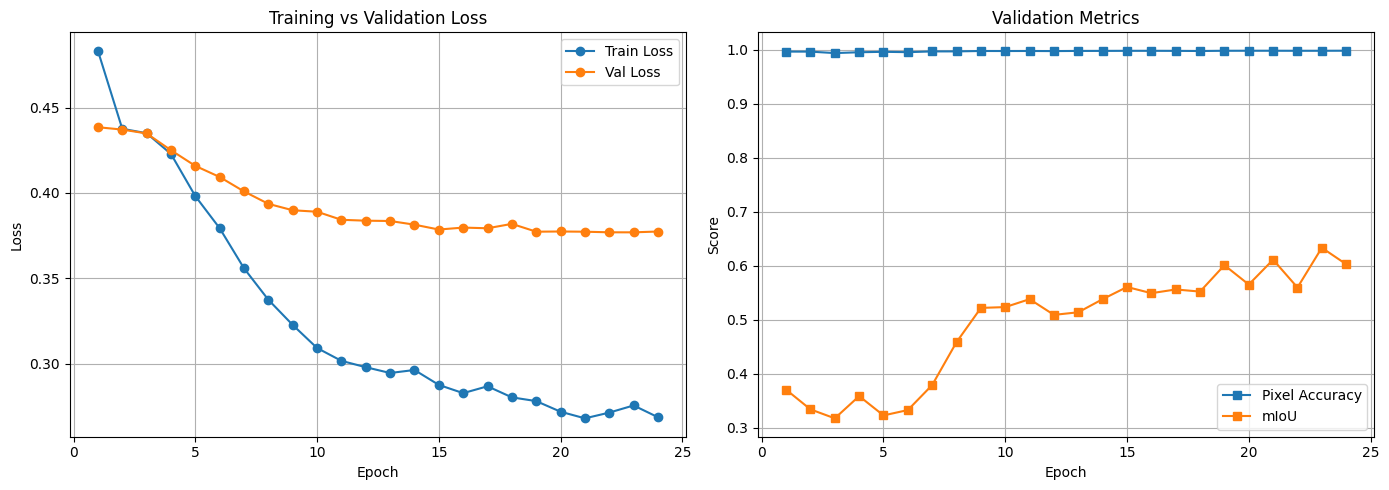

  Current Learning Rate: 0.000100

================ Epoch 25/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0046, Dice Loss: 0.5476, Total Loss: 0.2761
  [Train] Batch 2/121 - CE Loss: 0.0048, Dice Loss: 0.5388, Total Loss: 0.2718
  [Train] Batch 3/121 - CE Loss: 0.0054, Dice Loss: 0.5196, Total Loss: 0.2625
  [Train] Batch 4/121 - CE Loss: 0.0045, Dice Loss: 0.6358, Total Loss: 0.3202
  [Train] Batch 5/121 - CE Loss: 0.0040, Dice Loss: 0.6478, Total Loss: 0.3259
  [Train] Batch 6/121 - CE Loss: 0.0056, Dice Loss: 0.5145, Total Loss: 0.2601
  [Train] Batch 7/121 - CE Loss: 0.0062, Dice Loss: 0.5259, Total Loss: 0.2660
  [Train] Batch 8/121 - CE Loss: 0.0047, Dice Loss: 0.5153, Total Loss: 0.2600
  [Train] Batch 9/121 - CE Loss: 0.0077, Dice Loss: 0.4867, Total Loss: 0.2472
  [Train] Batch 10/121 - CE Loss: 0.0037, Dice Loss: 0.5190, Total Loss: 0.2614
  [Train] Batch 11/121 - CE Loss: 0.0093, Dice Loss: 0.5551, Total Loss: 0.2822
  [Train] Batch 12/121 - CE Loss: 0.

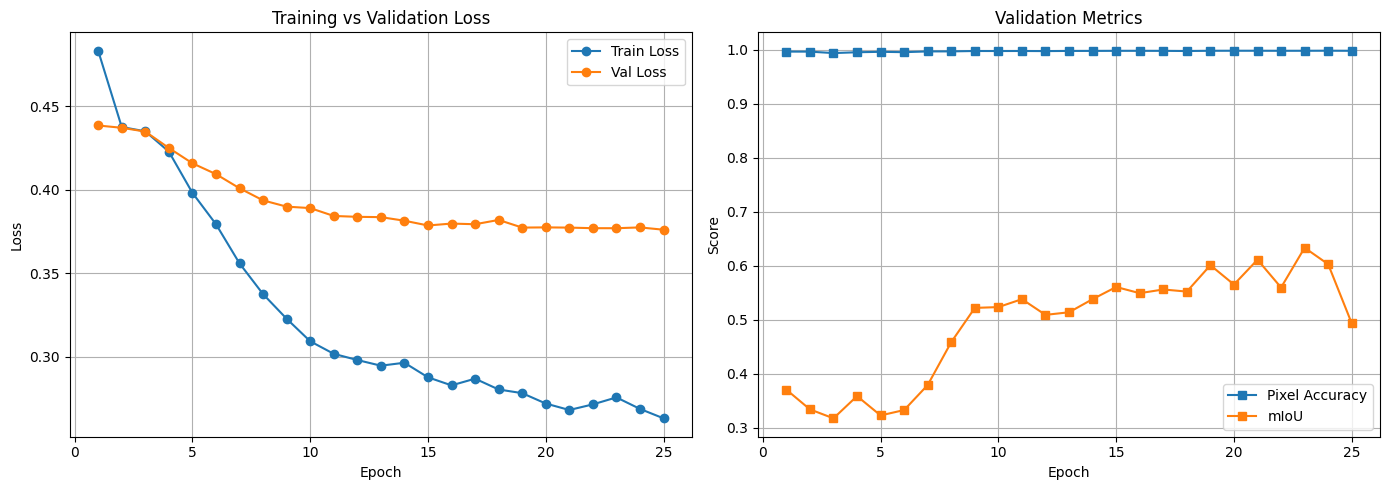

  Current Learning Rate: 0.000100

================ Epoch 26/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0070, Dice Loss: 0.6039, Total Loss: 0.3054
  [Train] Batch 2/121 - CE Loss: 0.0045, Dice Loss: 0.3951, Total Loss: 0.1998
  [Train] Batch 3/121 - CE Loss: 0.0037, Dice Loss: 0.5434, Total Loss: 0.2735
  [Train] Batch 4/121 - CE Loss: 0.0109, Dice Loss: 0.5083, Total Loss: 0.2596
  [Train] Batch 5/121 - CE Loss: 0.0046, Dice Loss: 0.5327, Total Loss: 0.2686
  [Train] Batch 6/121 - CE Loss: 0.0066, Dice Loss: 0.4575, Total Loss: 0.2321
  [Train] Batch 7/121 - CE Loss: 0.0076, Dice Loss: 0.4710, Total Loss: 0.2393
  [Train] Batch 8/121 - CE Loss: 0.0028, Dice Loss: 0.5177, Total Loss: 0.2602
  [Train] Batch 9/121 - CE Loss: 0.0069, Dice Loss: 0.5349, Total Loss: 0.2709
  [Train] Batch 10/121 - CE Loss: 0.0044, Dice Loss: 0.5221, Total Loss: 0.2633
  [Train] Batch 11/121 - CE Loss: 0.0053, Dice Loss: 0.5501, Total Loss: 0.2777
  [Train] Batch 12/121 - CE Loss: 0.

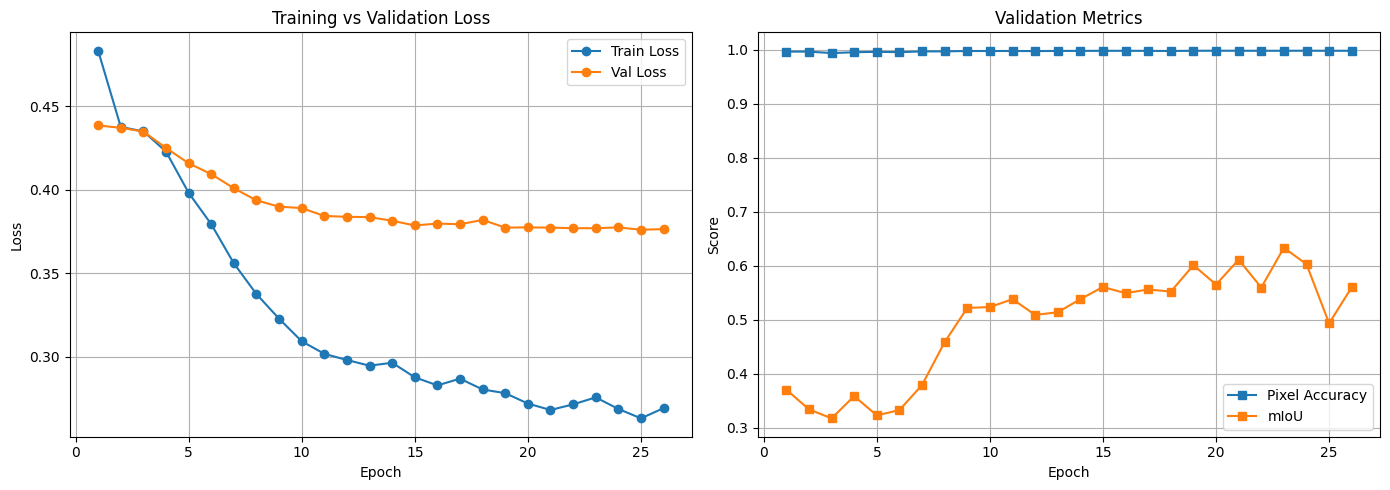

  Current Learning Rate: 0.000100

================ Epoch 27/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0046, Dice Loss: 0.6405, Total Loss: 0.3226
  [Train] Batch 2/121 - CE Loss: 0.0047, Dice Loss: 0.6325, Total Loss: 0.3186
  [Train] Batch 3/121 - CE Loss: 0.0058, Dice Loss: 0.6597, Total Loss: 0.3327
  [Train] Batch 4/121 - CE Loss: 0.0100, Dice Loss: 0.6579, Total Loss: 0.3340
  [Train] Batch 5/121 - CE Loss: 0.0041, Dice Loss: 0.4814, Total Loss: 0.2428
  [Train] Batch 6/121 - CE Loss: 0.0045, Dice Loss: 0.3895, Total Loss: 0.1970
  [Train] Batch 7/121 - CE Loss: 0.0031, Dice Loss: 0.5071, Total Loss: 0.2551
  [Train] Batch 8/121 - CE Loss: 0.0032, Dice Loss: 0.5256, Total Loss: 0.2644
  [Train] Batch 9/121 - CE Loss: 0.0036, Dice Loss: 0.5273, Total Loss: 0.2655
  [Train] Batch 10/121 - CE Loss: 0.0052, Dice Loss: 0.4577, Total Loss: 0.2314
  [Train] Batch 11/121 - CE Loss: 0.0166, Dice Loss: 0.6835, Total Loss: 0.3500
  [Train] Batch 12/121 - CE Loss: 0.

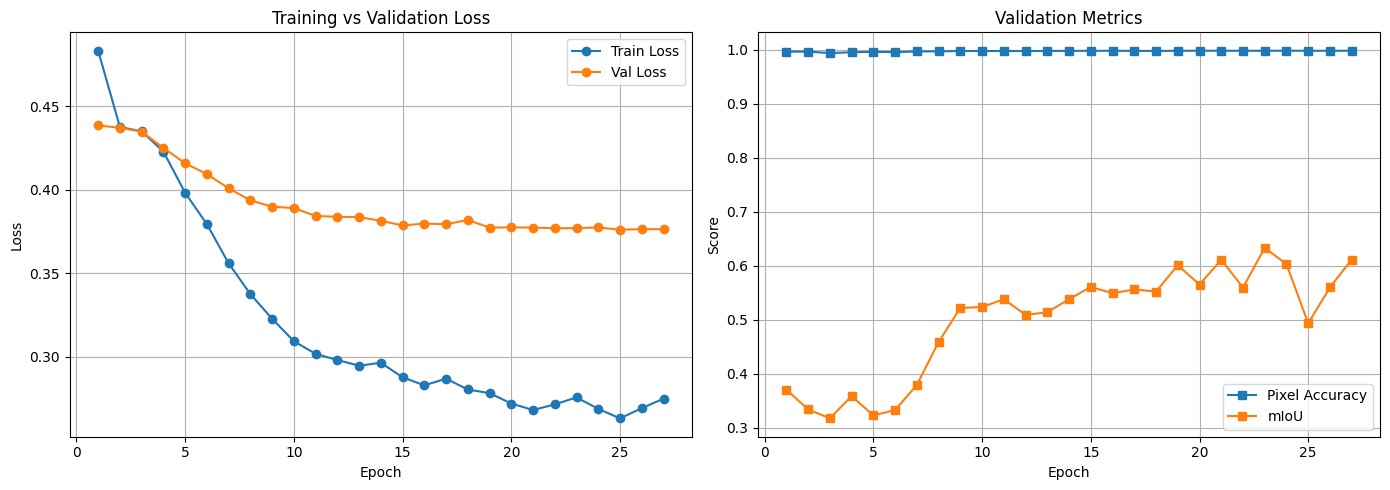

  Current Learning Rate: 0.000100

================ Epoch 28/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0069, Dice Loss: 0.4647, Total Loss: 0.2358
  [Train] Batch 2/121 - CE Loss: 0.0032, Dice Loss: 0.5248, Total Loss: 0.2640
  [Train] Batch 3/121 - CE Loss: 0.0071, Dice Loss: 0.5084, Total Loss: 0.2578
  [Train] Batch 4/121 - CE Loss: 0.0061, Dice Loss: 0.4215, Total Loss: 0.2138
  [Train] Batch 5/121 - CE Loss: 0.0028, Dice Loss: 0.5269, Total Loss: 0.2649
  [Train] Batch 6/121 - CE Loss: 0.0049, Dice Loss: 0.5198, Total Loss: 0.2623
  [Train] Batch 7/121 - CE Loss: 0.0041, Dice Loss: 0.4286, Total Loss: 0.2163
  [Train] Batch 8/121 - CE Loss: 0.0064, Dice Loss: 0.5432, Total Loss: 0.2748
  [Train] Batch 9/121 - CE Loss: 0.0087, Dice Loss: 0.5477, Total Loss: 0.2782
  [Train] Batch 10/121 - CE Loss: 0.0063, Dice Loss: 0.5333, Total Loss: 0.2698
  [Train] Batch 11/121 - CE Loss: 0.0033, Dice Loss: 0.4492, Total Loss: 0.2263
  [Train] Batch 12/121 - CE Loss: 0.

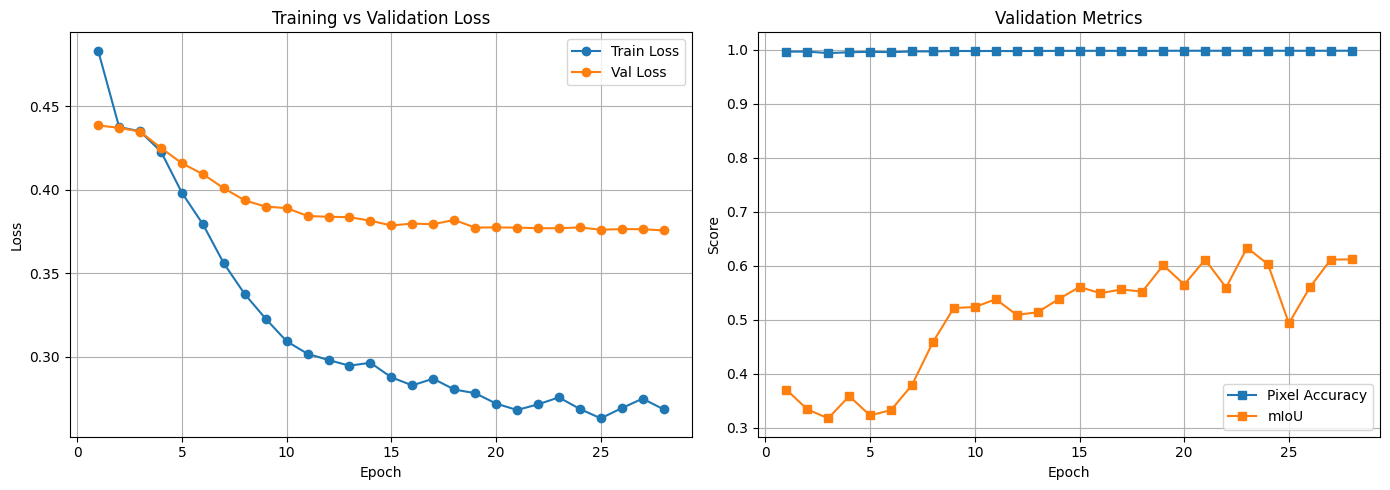

  Current Learning Rate: 0.000100

================ Epoch 29/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0040, Dice Loss: 0.4185, Total Loss: 0.2113
  [Train] Batch 2/121 - CE Loss: 0.0065, Dice Loss: 0.5363, Total Loss: 0.2714
  [Train] Batch 3/121 - CE Loss: 0.0024, Dice Loss: 0.5353, Total Loss: 0.2688
  [Train] Batch 4/121 - CE Loss: 0.0050, Dice Loss: 0.6477, Total Loss: 0.3263
  [Train] Batch 5/121 - CE Loss: 0.0026, Dice Loss: 0.3903, Total Loss: 0.1965
  [Train] Batch 6/121 - CE Loss: 0.0034, Dice Loss: 0.6262, Total Loss: 0.3148
  [Train] Batch 7/121 - CE Loss: 0.0117, Dice Loss: 0.5451, Total Loss: 0.2784
  [Train] Batch 8/121 - CE Loss: 0.0036, Dice Loss: 0.5102, Total Loss: 0.2569
  [Train] Batch 9/121 - CE Loss: 0.0040, Dice Loss: 0.5239, Total Loss: 0.2640
  [Train] Batch 10/121 - CE Loss: 0.0076, Dice Loss: 0.4258, Total Loss: 0.2167
  [Train] Batch 11/121 - CE Loss: 0.0032, Dice Loss: 0.4997, Total Loss: 0.2515
  [Train] Batch 12/121 - CE Loss: 0.

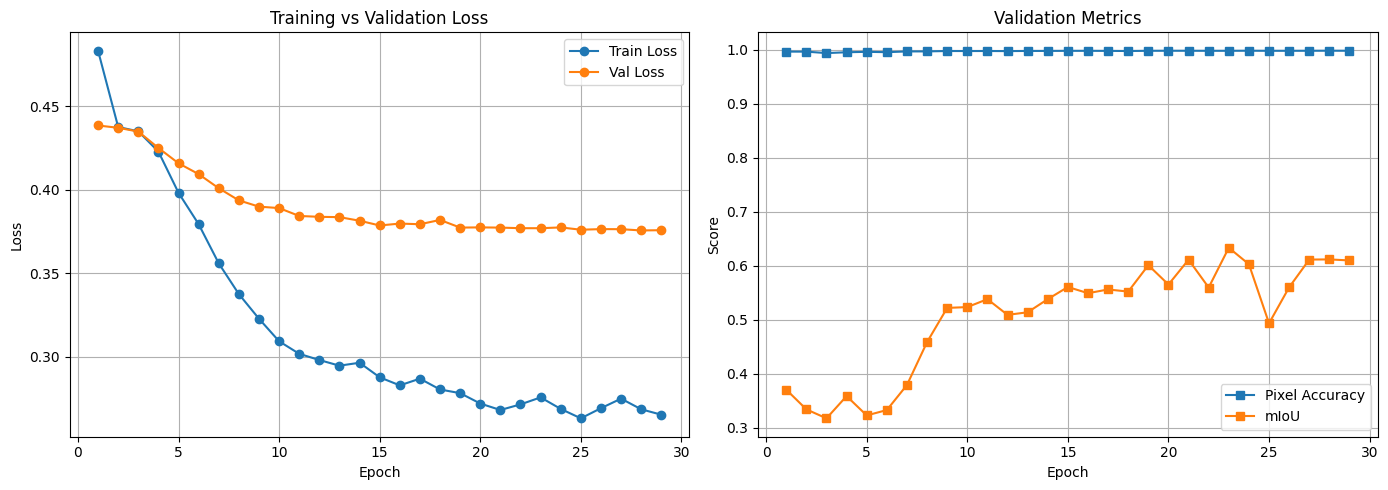

  Current Learning Rate: 0.000100

================ Epoch 30/30 ================

[Training]
  [Train] Batch 1/121 - CE Loss: 0.0036, Dice Loss: 0.5566, Total Loss: 0.2801
  [Train] Batch 2/121 - CE Loss: 0.0061, Dice Loss: 0.5075, Total Loss: 0.2568
  [Train] Batch 3/121 - CE Loss: 0.0043, Dice Loss: 0.5179, Total Loss: 0.2611
  [Train] Batch 4/121 - CE Loss: 0.0028, Dice Loss: 0.5099, Total Loss: 0.2563
  [Train] Batch 5/121 - CE Loss: 0.0037, Dice Loss: 0.5266, Total Loss: 0.2652
  [Train] Batch 6/121 - CE Loss: 0.0040, Dice Loss: 0.4941, Total Loss: 0.2490
  [Train] Batch 7/121 - CE Loss: 0.0126, Dice Loss: 0.6314, Total Loss: 0.3220
  [Train] Batch 8/121 - CE Loss: 0.0031, Dice Loss: 0.6269, Total Loss: 0.3150
  [Train] Batch 9/121 - CE Loss: 0.0050, Dice Loss: 0.4422, Total Loss: 0.2236
  [Train] Batch 10/121 - CE Loss: 0.0068, Dice Loss: 0.6231, Total Loss: 0.3150
  [Train] Batch 11/121 - CE Loss: 0.0047, Dice Loss: 0.5252, Total Loss: 0.2650
  [Train] Batch 12/121 - CE Loss: 0.

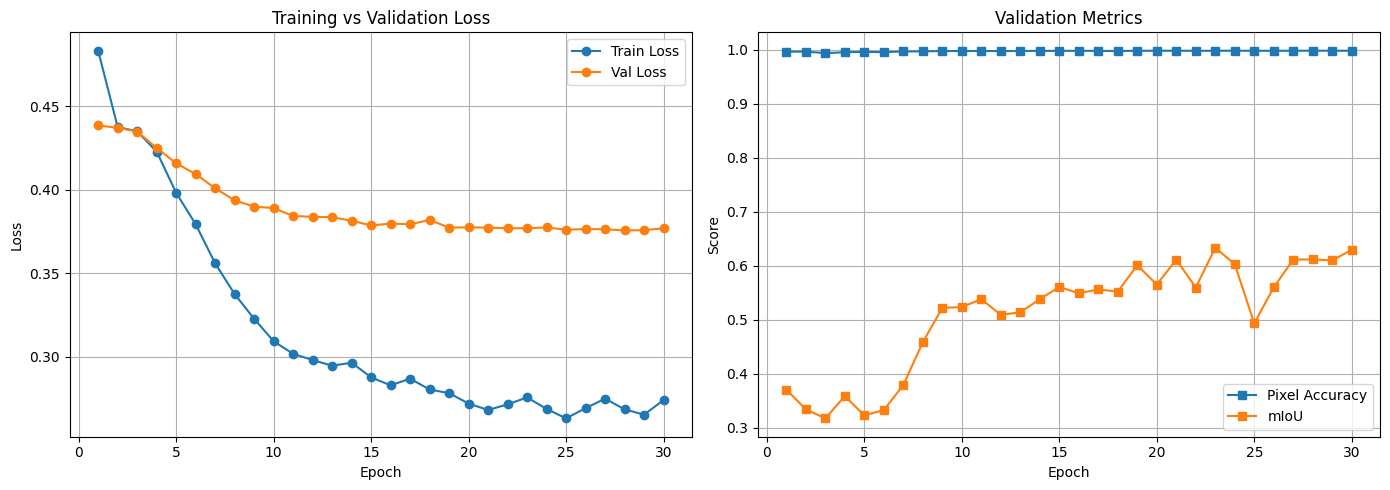

  Current Learning Rate: 0.000100


In [10]:
# -------- Training + Validation Loop --------
def train_model(num_epochs=10):
    for epoch in range(num_epochs):
        print(f"\n================ Epoch {epoch+1}/{num_epochs} ================\n")

        # ========== TRAINING ==========
        model.train()
        running_train_loss = 0.0
        print("[Training]")

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            # ---- Hybrid Loss: CrossEntropy + Dice ----
            ce_loss = focal_loss(outputs, masks)
            d_loss = dice_loss(outputs, masks)
            loss = 0.5 * ce_loss + 0.5 * d_loss
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            print(f"  [Train] Batch {batch_idx+1}/{len(train_loader)} - CE Loss: {ce_loss.item():.4f}, Dice Loss: {d_loss.item():.4f}, Total Loss: {loss.item():.4f}")

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        print(f"→ Epoch {epoch+1} Average Train Loss: {avg_train_loss:.4f}")

        # ========== VALIDATION ==========
        model.eval()
        running_val_loss = 0.0
        pixel_acc_total = 0.0
        miou_total = 0.0
        class_acc_total = np.zeros(7)
        val_batch_count = 0

        print("[Validation]")
        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(val_loader):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                 # Use same hybrid loss in validation
                ce_loss = focal_loss(outputs, masks)
                d_loss = dice_loss(outputs, masks)
                loss = 0.5 * ce_loss + 0.5 * d_loss

                running_val_loss += loss.item()
                print(f"  [Val] Batch {batch_idx+1}/{len(val_loader)} - CE Loss: {ce_loss.item():.4f}, Dice Loss: {d_loss.item():.4f}, Total Loss: {loss.item():.4f}")

                probs = torch.softmax(outputs, dim=1)
                pixel_acc, miou, per_class_acc = compute_metrics(probs, masks)
                pixel_acc_total += pixel_acc
                miou_total += miou
                class_acc_total += per_class_acc
                val_batch_count += 1

        avg_val_loss = running_val_loss / len(val_loader)
        avg_pixel_acc = pixel_acc_total / val_batch_count
        avg_miou = miou_total / val_batch_count
        avg_class_acc = class_acc_total / val_batch_count

        val_losses.append(avg_val_loss)
        val_pixel_accuracies.append(avg_pixel_acc)
        val_mious.append(avg_miou)

        print(f"\n→ Epoch {epoch+1} Summary:")
        print(f"  Train Loss     : {avg_train_loss:.4f}")
        print(f"  Val Loss       : {avg_val_loss:.4f}")
        print(f"  Pixel Accuracy : {avg_pixel_acc:.4f}")
        print(f"  Mean IoU       : {avg_miou:.4f}")
        for cls_idx, acc in enumerate(avg_class_acc):
            print(f"  Class {cls_idx} Accuracy: {acc:.4f}")

        # ========== OPTIONAL: Plot Live ==========
        plot_metrics(epoch + 1)
        scheduler.step(avg_val_loss)  # Step the LR scheduler
        print(f"  Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

# -------- Run Training --------
train_model(num_epochs=30)  # Increase this as needed


Image 1
Original Mask Unique Values: [0 2]
Predicted Mask Unique Values: [0 2]


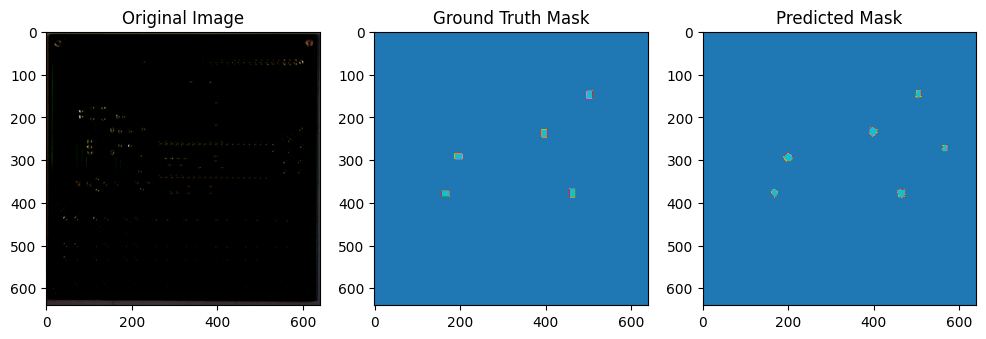

  Pixel Accuracy : 0.9982
  Mean IoU       : 0.7864

Image 2
Original Mask Unique Values: [0 2]
Predicted Mask Unique Values: [0 2]


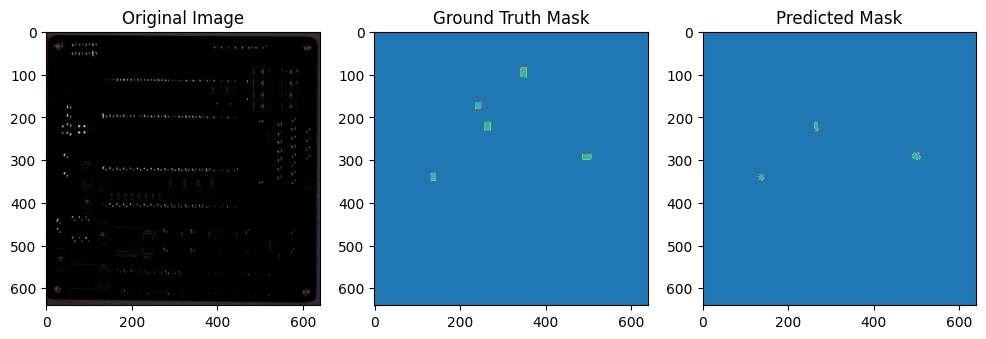

  Pixel Accuracy : 0.9978
  Mean IoU       : 0.6963

Image 3
Original Mask Unique Values: [0 2]
Predicted Mask Unique Values: [0 2]


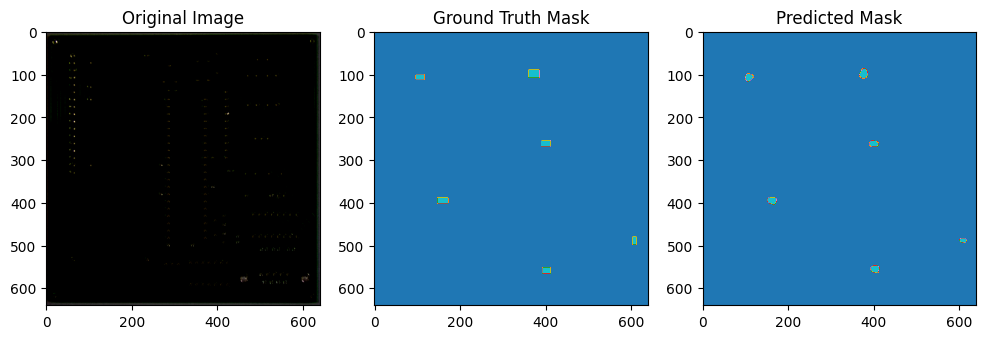

  Pixel Accuracy : 0.9981
  Mean IoU       : 0.8157

Image 4
Original Mask Unique Values: [0 2]
Predicted Mask Unique Values: [0 2 3]


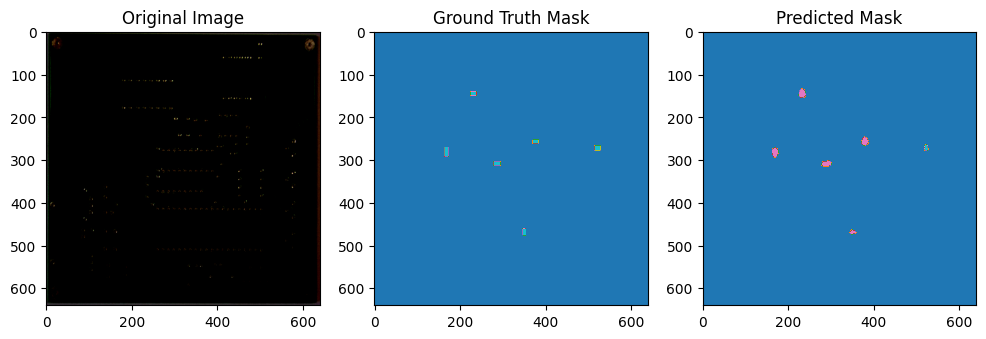

  Pixel Accuracy : 0.9981
  Mean IoU       : 0.4894

Image 5
Original Mask Unique Values: [0 2]
Predicted Mask Unique Values: [0 2]


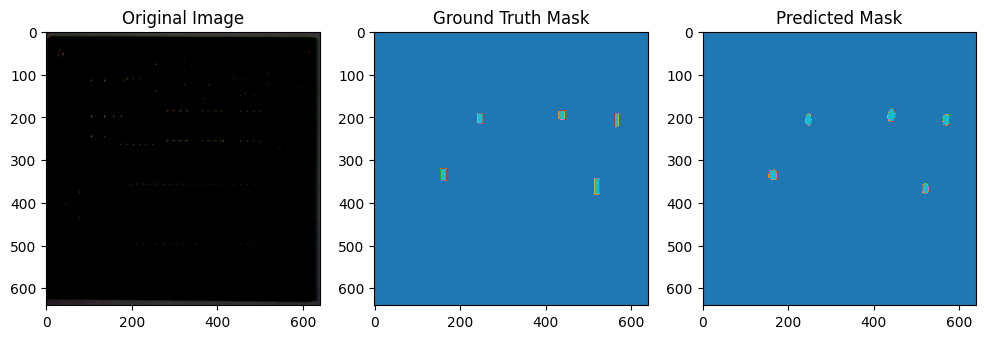

  Pixel Accuracy : 0.9980
  Mean IoU       : 0.8160

Image 6
Original Mask Unique Values: [0 2]
Predicted Mask Unique Values: [0 2]


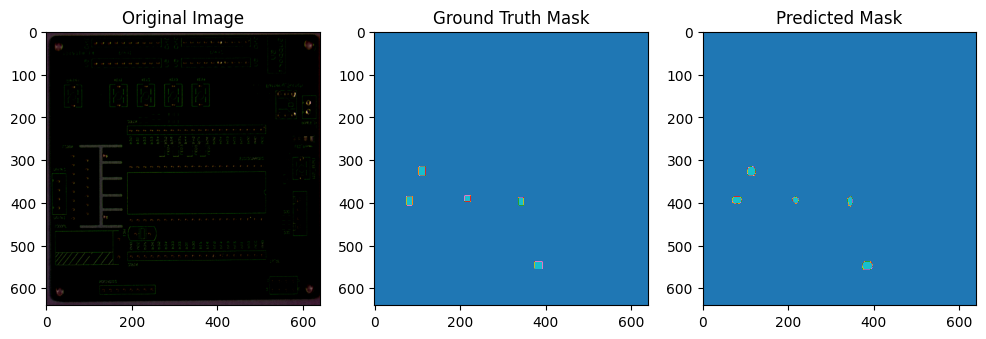

  Pixel Accuracy : 0.9987
  Mean IoU       : 0.8386

Image 7
Original Mask Unique Values: [0 2]
Predicted Mask Unique Values: [0 2]


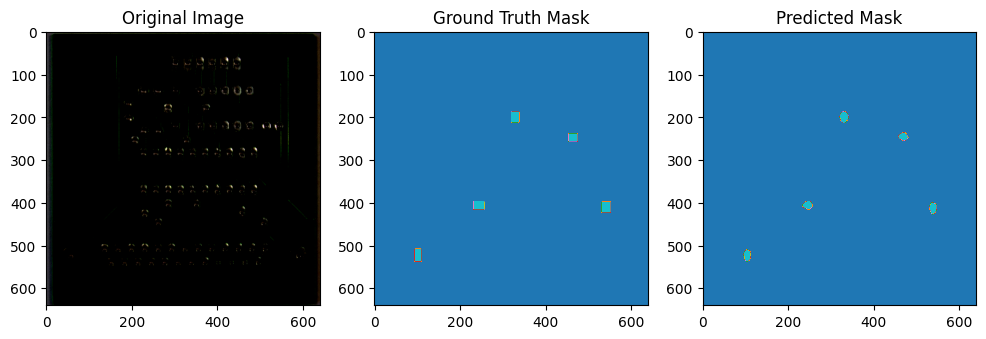

  Pixel Accuracy : 0.9978
  Mean IoU       : 0.8181

Image 8
Original Mask Unique Values: [0 2]
Predicted Mask Unique Values: [0 2 3]


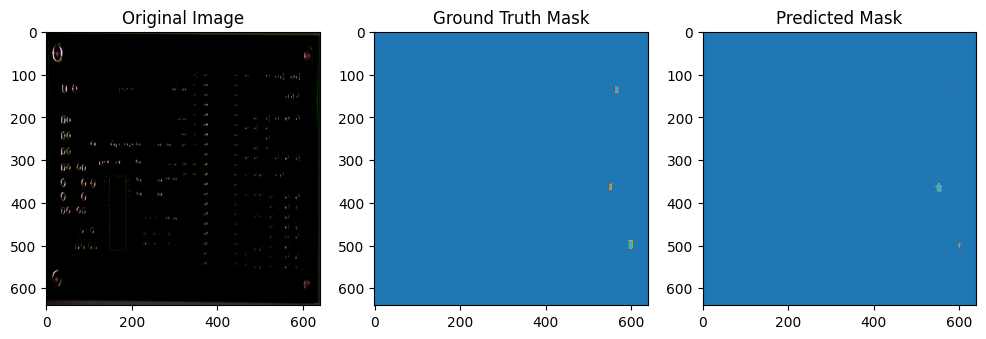

  Pixel Accuracy : 0.9988
  Mean IoU       : 0.3403

Image 9
Original Mask Unique Values: [0 2]
Predicted Mask Unique Values: [0 3]


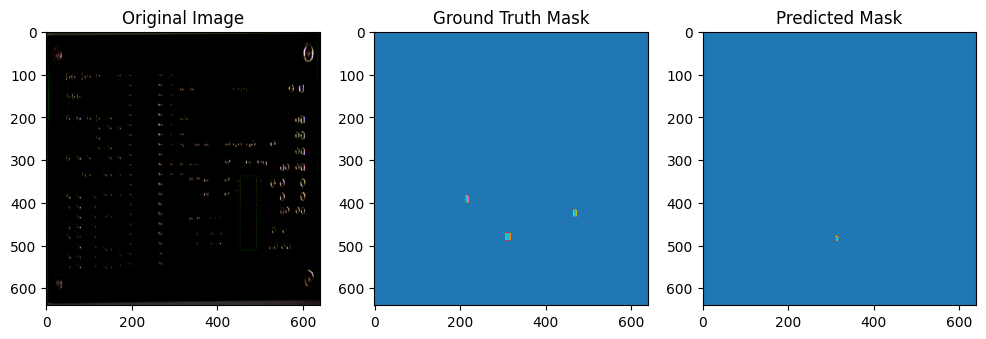

  Pixel Accuracy : 0.9989
  Mean IoU       : 0.3330

Image 10
Original Mask Unique Values: [0 2]
Predicted Mask Unique Values: [0 2 5]


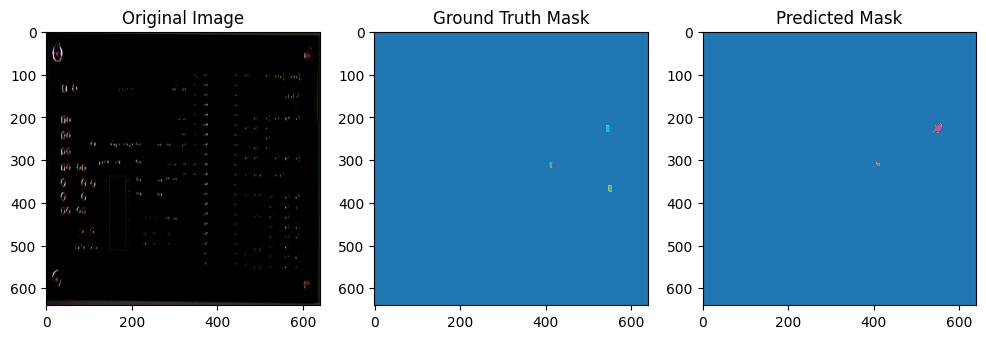

  Pixel Accuracy : 0.9990
  Mean IoU       : 0.4196


In [11]:
def visualize_all_predictions(model, test_loader, max_images=None):
    model.eval()
    image_count = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            batch_size = images.size(0)
            for i in range(batch_size):
                image_np = images[i].cpu().permute(1, 2, 0).numpy()
                mask_np = masks[i].cpu().numpy()
                pred_np = preds[i].cpu().numpy()

                print(f"\nImage {image_count + 1}")
                print("Original Mask Unique Values:", np.unique(mask_np))
                print("Predicted Mask Unique Values:", np.unique(pred_np))

                # Plotting
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(image_np)

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth Mask")
                plt.imshow(mask_np, cmap='tab10')

                plt.subplot(1, 3, 3)
                plt.title("Predicted Mask")
                plt.imshow(pred_np, cmap='tab10')
                plt.show()

                # Optional: Compute metrics for each image
                pix, mio, per_class = compute_metrics(outputs[i].unsqueeze(0), masks[i].unsqueeze(0))
                print(f"  Pixel Accuracy : {pix:.4f}")
                print(f"  Mean IoU       : {mio:.4f}")

                image_count += 1
                if max_images is not None and image_count >= max_images:
                    return
visualize_all_predictions(model, test_loader, max_images=10)  # or None to show all

In [12]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
# Read grayscale mask
mask = Image.open("/kaggle/input/split-dataset-pcb-defect/train/masks/Mouse_bite/01_mouse_bite_03.png").convert("L")  # 'L' = 8-bit grayscale

# Convert to tensor
mask = torch.from_numpy(np.array(mask)).long()  # Important: long dtype for CrossEntropyLoss
print(np.unique(mask))


[0 2]


Unique values in the mask: [0 2]


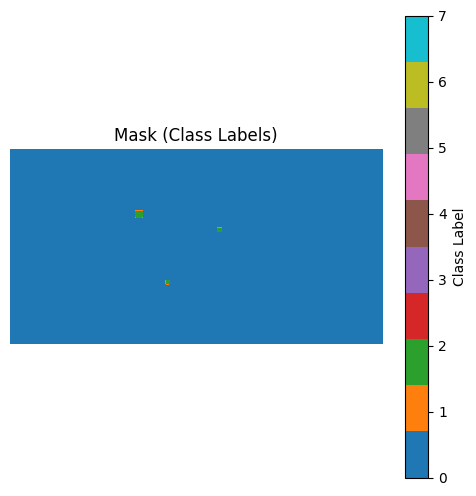

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Load mask image (grayscale class label image) ---
mask_path = "/kaggle/input/split-dataset-pcb-defect/train/masks/Mouse_bite/01_mouse_bite_03.png"  # <-- change this to your actual path
mask = Image.open(mask_path).convert("L")  # Load as grayscale
mask_np = np.array(mask)

# --- Print unique values (should be 0–6 only) ---
print("Unique values in the mask:", np.unique(mask_np))

# --- Plot the mask with colormap ---
plt.figure(figsize=(6, 6))
plt.title("Mask (Class Labels)")
plt.imshow(mask_np, cmap="tab10", vmin=0, vmax=7)  # tab10 gives distinct colors
plt.colorbar(label='Class Label')
plt.axis("off")
plt.show()
